<a href="https://colab.research.google.com/github/dolmani38/ai_corona/blob/master/analysis_corona_0509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[목차]**


---


1. 분석 개요
2. 분석 환경
3. Data 추출 및 전처리

	3.1 Roaming dataset load 및 전처리
		3.1.1 Roaming dataset load
		3.1.2 일자별 그룹핑
		3.1.3 일자별, 국가별 그룹핑
	3.2 COVID-19 word wide dataset load 및 전처리 (추가 Data)
		3.2.1 COVID-19 word wide dataset load
		3.2.2 Roaming Dataset과 join
	3.3 News dataset load 및 전처리
		3.3.1 News dataset load 
		3.3.2 'COVID-19' 만 구분
		3.3.3 News BERT embedding
		3.3.4 6 Features 추출
		3.3.5 일별 6 Features 그룹핑
		3.3.6 6 Features Normalization
		3.3.7 Outlier 제거
	3.4 전체 Dataset 구성<br><br>

4. Timeseries deep learning model Test

	4.1 1D Convolution CNN Model Test
		4.1.1 30일 window, 15일 일괄 예측 Model Test
		4.1.2 30일 window, 15일 일괄 예측 Ensemble Model Test
		4.1.3 40일 window, 1일 예측 후 15일 재귀적 예측 Model Test
		4.1.4 40일 window, 1일 예측 후 15일 재귀적 예측 Ensemble Model Test
	4.2 LSTM Model Test
		4.2.1 30일 window, 15일 일괄 예측 Model Test
		4.2.2 30일 window, 15일 일괄 예측 Ensemble Model Test
		4.2.3 40일 window, 15일 재귀적 예측 Model Test
		4.2.4 40일 window, 15일 재귀적 예측 Ensemble Model Test

5. 향후 15일 예측 결과

	5.1 Model의 선택

	5.2 40일 window, 15일 재귀적 예측 Ensemble LSTM Model

	5.3 향후 15일 예측 결과

 

---




1. 분석 개요
![대체 텍스트](http://www.aihub.or.kr/sites/default/files/(%E1%84%80%E1%85%A1%E1%86%B7%E1%84%8B%E1%85%A7%E1%86%B7%E1%84%87%E1%85%A7%E1%86%BC%E1%84%8B%E1%85%A8%E1%84%87%E1%85%A1%E1%86%BC%E1%84%80%E1%85%A9%E1%86%BC%E1%84%86%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB)(AI%20Hub)%E1%84%90%E1%85%A1%E1%84%8B%E1%85%B5%E1%84%90%E1%85%B3%E1%86%AF.jpg)

(공모부문1) 모델링 개발
(주제) 해외의 감염병이 국내로 유입될 위험도 산출 모델링
- 5월5일까지의 데이터 활용하여, 5월6~19일까지 유입 확진자 수 예측
활용데이터: 공모전 제공 기본 데이터 + 기타 자율수집데이터
o 공모전 제공 데이터: 전 세계 질병 관련 뉴스 데이터, KT 가입자 로밍 통계 데이터
o 공모전 제공 데이터는 3회에 걸쳐 제공
- 1차 배포(4월 6일) : 2019년 12월 1일 ~ 2020년 3월 31일까지의 수집 데이터
- 2차 배포(4월 29일) : 2020년 4월 1일 ~ 2020년 4월 28일까지의 수집 데이터
- 3차 배포(5월 6일) : 2020년 4월 29일 ~ 2020년 5월 5일까지의 수집 데이터
 평가방식: 모델 예측 결과와 실제 유입 확진자 발생의 오차
- 예선심사(~5월17일), 본선심사(5월18~20일), 결선심사(5월22일)
- 대상, 최우수상 수상작은 KT 글로벌 감염병 확산방지 플랫폼(Global Epidemic Prevention Platform)에 활용될 수 있음

모델링 개발 Desciption
모델링 개발 배경
- 2019년 중국에서 발생한 COVID-19는 2020년 현재 전 세계로 퍼지게 되었습니다. 우리나라 역시 초기에는 중국에서 유입된 바이러스가 전국으로 확산되면서 만 명이 넘는 확진자가 발생하였습니다. 대구/경북 지역에서 발생한 확산세가 진정 국면에 접어들면서 현재는 해외에서의 감염병 유입을 차단하는 것이 다시 중요한 문제가 되었습니다.
- 이에 따라 정부는 특별입국절차를 만들어 해외에서의 입국의 수요를 감소시키는 정책을 진행하고 있습니다. 이를 통해 국내로 입국하는 내/외국인의 숫자가 현저하게 줄어들어 감염병의 유입 위험을 감소시키기는 하였지만, 이러한 조치는 막대한 경제적인 피해를 동반하게 됩니다.
-따라서, 어느 시점에 국내 입국절차를 원위치해야 하는지를 언젠가는 의사결정을 해야 합니다. 이를 위해서는 해외에서 유입되는 확진자의 규모를 예측할 수 있어야 합니다.
- 본 공모전은, KT가 제공하는 해외 로밍 이용객 통계정보와 전 세계의 감염병과 관련된 뉴스 정보를 2019년 12월 ~ 2020년 5월 5일까지 기본 데이터로 제공하여, 여기에 각 팀별로 해외유입 확진자 수를 예측하기 위해 다양한 정보를 활용하여 향후 2주간의 유입 확진자의 수를 예측하는 모델을 만드는 것을 목표로 합니다.

모델링 제공 데이터 안내
로밍 데이터
- KT 로밍 이용고객 전체 데이터를 활용하여 생성한 통계 데이터로, 체류 국가의 입국/출국 날짜 및 여행자수 정보 제공
※ 데이터 구조
![대체 텍스트](http://www.aihub.or.kr/sites/default/files/2-1.%20%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C%20%EC%95%88%EB%82%B4_%EB%A1%9C%EB%B0%8D%EB%8D%B0%EC%9D%B4%ED%84%B0.png)

 

감염병 기사 데이터
- 해외 감염병 발병 기사를 수집한 데이터로 WHO, CDC 등 주요기관에서 감염병 발생 확인을 위해 사용하는 데이터와 동일한 수준의 데이터
※ 데이터 구조
![대체 텍스트](http://www.aihub.or.kr/sites/default/files/2-2.%20%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C%20%EC%95%88%EB%82%B4_%EA%B0%90%EC%97%BC%EB%B3%91%20%EA%B8%B0%EC%82%AC%20%EB%8D%B0%EC%9D%B4%ED%84%B0.png)


In [2]:
# 2. 분석 환경

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa itlb_multihit
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits 

In [3]:
!cat /proc/meminfo

MemTotal:       13333556 kB
MemFree:        10529212 kB
MemAvailable:   12459708 kB
Buffers:           74596 kB
Cached:          2010756 kB
SwapCached:            0 kB
Active:           728104 kB
Inactive:        1790208 kB
Active(anon):     409724 kB
Inactive(anon):      340 kB
Active(file):     318380 kB
Inactive(file):  1789868 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               564 kB
Writeback:             0 kB
AnonPages:        433016 kB
Mapped:           222612 kB
Shmem:               952 kB
Slab:             165700 kB
SReclaimable:     126288 kB
SUnreclaim:        39412 kB
KernelStack:        3592 kB
PageTables:         5260 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    2505420 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

In [2]:
!nvidia-smi

Sun May 10 03:15:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
!pip list

Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
asgiref                  3.2.7          
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.4.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.1.0          
beautifulsoup4           4.6.3          
bleach                   3.1.5          
blis                     0.4.1          
bokeh                    1.4.0          
boto                     2.49.0         
boto3                    1.13.3         
botocore                 1.16.3         
Bottleneck      

In [0]:
# 분석에 필요한 많이 쓰는 함수 미리 정의
import dill
import keras
import numpy as np
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Activation, Flatten
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def plot_train_result(hist):
    """
    학습의 결과, epoch 당 mean_absolute_error, R square, accuracy 등의 값을 Chart로 나타낸다.
    :param hist: hist = model.fit(....)
    :return:
    """
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    if 'mae' in hist.history:
        color = 'tab:red'
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('mean absolute error',color=color)
        plt.plot(hist.history['mae'],color=color)
        ax1.tick_params(axis='y', labelcolor=color)

    if 'r2' in hist.history:
        color = 'tab:blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('R square',color=color)
        plt.plot(hist.history['r2'],color=color)
        ax2.tick_params(axis='y', labelcolor=color)

    if 'acc' in hist.history:
        color = 'tab:blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('accuracy',color=color)
        plt.plot(hist.history['acc'],color=color)
        ax2.tick_params(axis='y', labelcolor=color)
    plt.title('Train history')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


def compare_with_past_y(past_y=None, comp_y=None, comp_index=[0, 14], forecast_y=None, window=30, forecast=15, title='Forecast result'):
    """
    최초 output으로 설정한 y값 대비, 예측한 결과 predit_y 값을 대조하여 Chart로 표출 한다.
    :param past_y:  Trainset의 y값 (DataFrame)
    :param comp_y: Trainset으로 예측한 결과값 (array)
    :param comp_index: 예측한 결과 predit_y 값은 1일 후~15일 후 등, 배열의 형태, 몇번째 값을 표출 할지 설정
                        예: comp_index = [0,14]
                            1일차 및 15일차의 예측 값에 해당.
    :param forecast_y : Testset으로 예측한 결과값 (array)
    :param window: time step 또는 몇일간의 시계열 정보를 input으로 할지 설정
                    해당 값은 sliding window (or moving average) 개념으로 dataset을 scan 하는 개념임
    :param forecast: window 구간 이후 향후 몇일 간을 예측할지 설정
                    즉, regression으로 논하면 output의 개수에 해당.
    :param title:차트의 title
    :return:
    """
    predit = []
    for fc in range(forecast):
        predit.append(list(np.concatenate((np.zeros(window + fc), comp_y[:, fc], np.zeros(forecast - fc - 1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    plt.figure(figsize=(16,8))
    plt.title('Display of past and future forecasts')
    plt.plot(past_y, label='past y')
    comp_ds = past_y.copy()
    for i in comp_index:
        comp_ds['past forecast ' + str(i)] = predit[i]
        plt.plot(comp_ds['past forecast ' + str(i)], label='past forecast ' + str(i))
    if not forecast_y is None:
      plt.plot(forecast_y,label='future forecast')
    plt.legend(loc="upper right")
    plt.show()


def display_result(predit_y, ds_y, title=None):
    """
    예측 결과를 chart로 표출 한다.
    :param predit_y: 예측한 결과값 베열
    :param ds_y: 원시 y 값 (실측치)
    :param title:
    :return:
    """
    predic_ds = []
    # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
    # predit_y1 = predit_y * 100/24
    from datetime import datetime, timedelta
    last_date = ds_y.index[-1]
    for predict_count in predit_y[0]:
        last_date += timedelta(days=1)
        predic_ds.append({'date': last_date, 'Roaming register forecate': predict_count,
                          'Immigrantion forecast': int(predict_count * 100 / 24)})
    predic_ds = pd.DataFrame(predic_ds).set_index('date')
    predic_ds.plot( y='Immigrantion forecast', kind='bar',
                   title=('immigrantion forecast' if title is None else title))
    return predic_ds


def create_timeseries_dataset(x, y, window=30, forecast=15):
    """
    *** 매우 중요한 funcation ***
    window size로 시계열 dataset의 input feature 값(train_x)과 forecast 기간의 실측 y값(train_y)
    시계열의 마지막 window 크기의 input feature 값(predict_x) 의 추출
    :param x: 실측 데이터 (pandas.DataFrame 형태)
    :param y: forecast 기간의 실측 y값(train_y, pandas.DataFrame 형태)
    :param window: 시계열 dataset의 input feature 값 size
    :param forecast: forecast 기간
                    예:'15'의 경우, window를 input으로 15개의 output을 regression 한다는 의미
    :return: train_x, train_y, predict_x
    """
    size = len(x.columns)
    train_x = []
    train_y = []

    x = x.to_numpy()
    y = y.to_numpy()
    print("input x:", x.shape)
    print("input y:", y.shape)
    for i in range(x.shape[0] - window - forecast + 1):
        sub_x = []
        for j in range(window):
            sub_x.append(x[i + j, :])
        train_x.append(sub_x)

        sub_y = []
        for z in range(forecast):
            sub_y.append(y[i + window + z,:])
        train_y.append(sub_y)

    # train_x ,train_y의 준비
    train_x = np.asarray(train_x)
    train_x = train_x.reshape(-1, window, size)
    train_y = np.asarray(train_y)
    if train_y.shape[2] ==1:
      train_y = train_y.reshape(-1,train_y.shape[1])
    elif train_y.shape[1] ==1:
      train_y = train_y.reshape(-1,train_y.shape[2])
    else:
      raise Exception('Not support shape!')

    predict_x = x[x.shape[0] - window:x.shape[0], :]
    predict_x = predict_x.reshape(-1, window, size)

    print("outout train_x:", train_x.shape)
    print("outout train_y:", train_y.shape)
    print("outout predict_x:", predict_x.shape)

    return train_x, train_y, predict_x


def create_model(input_shape=(30, 1), output=15, metrics=['mae', r2]):
    """
    1D Covolution의 Deep Neural Network model 구성. (keras 기반)
    :param input_shape: 입력 배열 구조 예) 100,15
    :param output: forecast 기간
                    예:'15'의 경우, window를 input으로 15개(15일)의 output을 regression 한다는 의미
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return: model
    """
    import keras
    from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
    from keras.models import Sequential

    model = Sequential()
    model.add(Conv1D(128, 4, input_shape=input_shape, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, 4, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, 4, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dense(output))
    model.add(Activation('linear'))

    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)

    model.summary()

    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
    print("save to model.json")

    return model

def create_lstm_model(input_shape=(30, 1), output=15, metrics=['mae', r2]):
    """
    LSTM Deep Neural Network model 구성. (keras 기반)
    참조:
    https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
    https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/    
    :param input_shape: 입력 배열 구조 예) 100,15
    :param output: forecast 기간
                    예:'15'의 경우, window를 input으로 15개(15일)의 output을 regression 한다는 의미
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return:
    """
    model = Sequential()
    model.add(LSTM(units=256, return_sequences = True, input_shape=input_shape))
    #model.add(LSTM(units=512,return_sequences = True, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dense(output))
    model.add(Activation('linear'))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=metrics)
    model.summary()

    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()

    print("save to model.json")
    return model

def train_model(model, x, y, epochs=30, trial=1, compile=False, verbose=0, metrics=['mae', r2]):
    """
    해당 model에 대한, 학습 시행
    :param model:
    :param x: 입력 x값
    :param y: 출력 y값 = label 개수
    :param epochs:
    :param trial: 1부터... 단지 print 용으로만
    :param compile: False - model을 compile하지 않는다.
                    True - 입력된 model을 compile 한다.
    :param verbose:
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return:
    """
    if compile:
        model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)
    # print(model.summary())
    print(str(trial), "th Trial")
    if verbose == 0:
        hist = model.fit(x, y, epochs=epochs, verbose=0, callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit(x, y, epochs=epochs, verbose=1)
    return model, hist

def ensemble_train(train_x,train_y,model_method=create_model, ensemble_count=25,epoch=200):
    model = model_method(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
    ensemble = []
    mae_list = []
    r2_list = []

    for i in range(ensemble_count):
      json_file = open("model.json", "r")
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json) 
      model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])
      model,hist = train_model(model,train_x,train_y,epochs=epoch,trial=(i+1))
      ensemble.append(model)
      mae_list.append(hist.history['mae'][-1])
      r2_list.append(hist.history['r2'][-1])

    print("Wait! saving ensemble model...")    
    file = open("ensemble.mdl", 'wb')
    dill.dump(ensemble, file)
    file.close()

    print("Complete!!")
    return ensemble, np.mean(mae_list), np.mean(r2_list)

# 		ensemble_predict method define~
def ensemble_predict(ensemble_model,input_x):
    if ensemble_model is None:
      print("load from model file...")
      file = open("ensemble.mdl", 'rb')
      ensemble = dill.load(file)
      file.close()
    ensemble_predit_y =  np.asarray([m.predict(input_x) for m in ensemble_model])
    predit_y = np.mean(ensemble_predit_y,axis=0)
    return predit_y, ensemble_predit_y


def mean_confidence_interval(data, confidence=0.95):
    """
    주어진 신뢰수준에서 구간추정
    :param data: 입력 array
    :param confidence: 신뢰수준
    :return: m : 평균
            m-h: 구간 시작
            m+h: 구간 끝
            std: 표준편차
    """
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    std = np.std(np.array(data))
    return m, m-h, m+h,std

def statistical_results_analysis(ensemble_predit_y,ds_y, title=None):
    """
    통계적 결과 분석
    신뢰수준에서 예측 구간추정 처리
    :param ensemble_predit_y: trainset 입력에 대한 앙상블 모델의 추정 결과
    :param ds_y: 실 로밍등록 추세
    :param title: 결과 dataframe
    :return: 
    """
    predic_ds = []
    last_date = ds_y.index[-1]
    ept = ensemble_predit_y.T
    for forecast_d in ept[:,0,:]:
      last_date += timedelta(days=1)
      m, mi,ma,std = mean_confidence_interval(forecast_d)
      ifmi = str(int(mi * 100/24))
      if mi < 0:
        ifmi=""
      predic_ds.append({'date':last_date,'Roaming register forecast(RRF)':int(m),'min':int(mi),'max':int(ma),
                        'RRF within the 95% confidence interval': str(int(mi)) + ' ~ ' + str(int(ma)),
                        'Standard deviation':std,
                        'Immigrantion forecast': ifmi + " ~ " + str(int(ma * 100/24))})
    predic_ds = pd.DataFrame(predic_ds).set_index('date')
    return predic_ds


def recursive_forecast(model,predict_x,recursion=15):
    predict = []
    for i in range(recursion):
      predit_y = model.predict(predict_x)
      predict.append(predit_y[0][0])
      new_predict_x = predict_x.reshape(predict_x.shape[1],predict_x.shape[2])
      new_predict_x = np.concatenate((new_predict_x, predit_y), axis=0)[1:window+1,:]
      predict_x = new_predict_x.reshape(1,new_predict_x.shape[0],new_predict_x.shape[1])
    return np.asarray(predict).reshape(1,recursion)


def ensemble_recursive_forecast(ensemble_model,input_x):
    if ensemble_model is None:
      print("load from model file...")
      file = open("ensemble.mdl", 'rb')
      ensemble = dill.load(file)
      file.close()
    ensemble_predit_y =  np.asarray([recursive_forecast(m,input_x) for m in ensemble_model])
    predit_y = np.mean(ensemble_predit_y,axis=0)
    return predit_y, ensemble_predit_y
    

def ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=200):
    model = create_lstm_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
    ensemble = []
    mae_list = []
    r2_list = []

    for i in range(ensemble_count):
      json_file = open("model.json", "r")
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json) 
      model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])
      model,hist = train_model(model,train_x,train_y,epochs=epoch,trial=(i+1))
      ensemble.append(model)
      mae_list.append(hist.history['mae'][-1])
      r2_list.append(hist.history['r2'][-1])

    print("Wait! saving ensemble model...")    
    file = open("ensemble.mdl", 'wb')
    dill.dump(ensemble, file)
    file.close()

    print("Complete!!")
    return ensemble, np.mean(mae_list), np.mean(r2_list)

class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else log)),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


In [4]:
#3. Data 추출 및 전처리
#	3.1 Roaming dataset load 및 전처리
#		3.1.1 Roaming dataset load

#공개된 3개의 Roaming Dataset을 load하여 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm3 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0506/Roaming_data.xlsx",encoding="utf-8")
rm = pd.concat([rm1,rm2,rm3], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
219020,20200501,vn,20200429,20200501,3
219021,20200501,vn,20200430,20200430,7
219022,20200501,vn,20200430,20200501,7
219023,20200501,vn,20200501,20200501,20


,count
arrival,
2019-10-31,91
2019-11-01,36
2019-11-02,120
2019-11-03,159
2019-11-04,179
...,...
2020-05-01,641
2020-05-02,502
2020-05-03,434


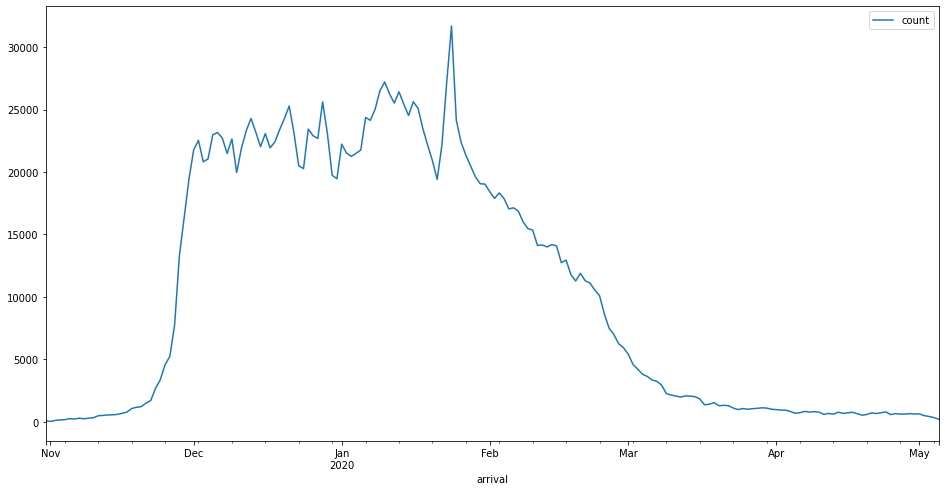

In [5]:
#		3.1.2 일자별 그룹핑


ds_y = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ds_y.index=  pd.to_datetime(ds_y.index, format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ds_y.plot(figsize=(16,8))
ds_y

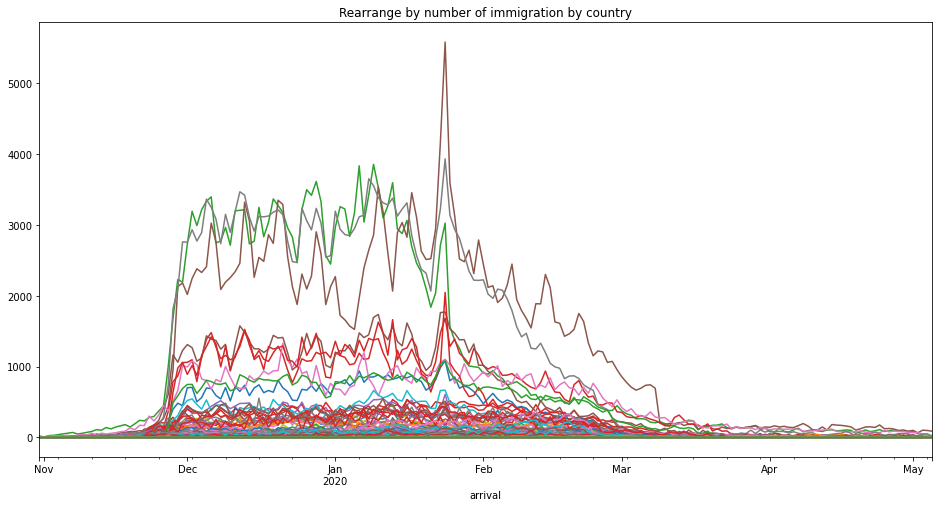

In [6]:
#		3.1.3 일자별, 국가별 그룹핑


ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
    if date == row[0][0]:
        pass
    else:
        if not r is None:
            rows.append(r)
        r = {}
    r['arrival'] = row[0][0]
    r[row[0][1]] = row[1][0]
    date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
#ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso.plot(legend=False,figsize=(16,8),title="Rearrange by number of immigration by country")

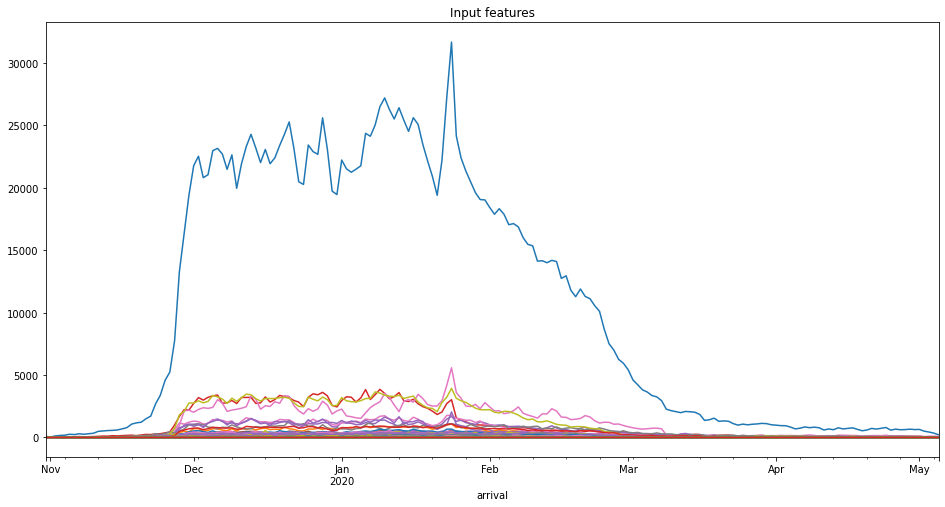

In [7]:
ds_y_iso = ds_y.join(ds_iso) # / np.max(ds_y.max())
ds_y_iso.plot(legend=False,figsize=(16,8),title='Input features')

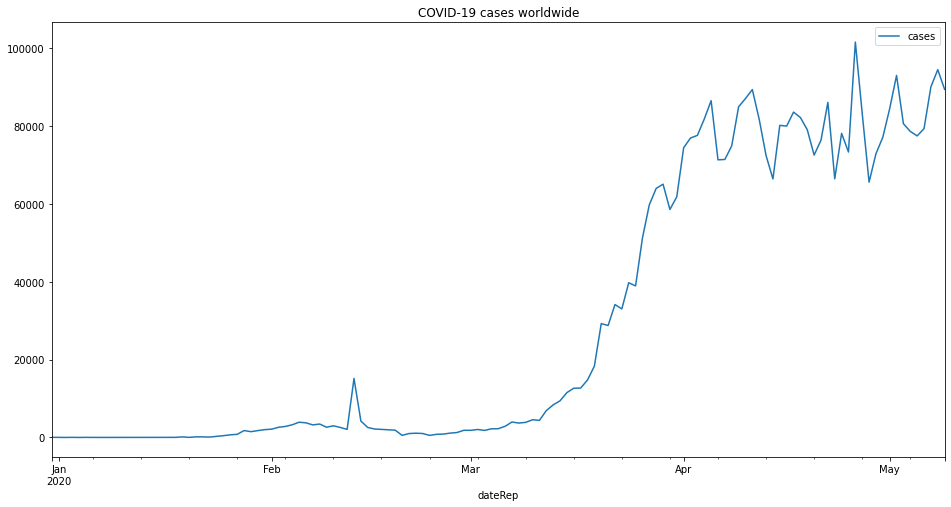

In [8]:
#	3.2 COVID-19 word wide dataset load 및 전처리 (추가 Data)
#		3.2.1 COVID-19 word wide dataset load

# 추가 데이터
# COVID-19 word wide dataset
# https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data

ds_cov_tp = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv",encoding="utf-8")
ds_cov = pd.DataFrame(ds_cov_tp.groupby('dateRep')['cases'].sum())
#date column을 datetime 으로 casting 한다.
ds_cov.index =  pd.to_datetime(ds_cov.index, format='%d/%m/%Y')
ds_cov = ds_cov.sort_index()
ds_cov.plot(figsize=(16,8),title='COVID-19 cases worldwide')


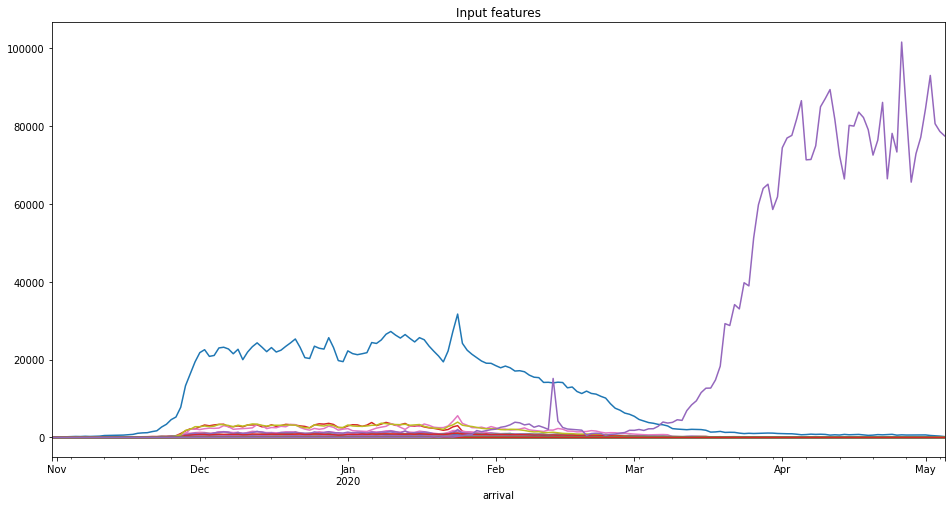

In [9]:
#		3.2.2 Roaming Dataset과 join

ds_y_iso_cov = ds_y_iso.join(ds_cov).fillna(0)
ds_y_iso_cov.plot(legend=False,figsize=(16,8),title='Input features')

In [10]:
#	3.3 News dataset load 및 전처리
#		3.3.1 News dataset load 

# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns3 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0506/NewsList.xls")

ds_ns_tp =pd.concat([ns1, ns2, ns3], ignore_index=True, sort=False)
ds_ns_tp

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
112608,XINH2020050500081,Russia's top spacecraft designer reportedly di...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05 21:06:31,Xinhua,COVID-19,Viral
112609,XINH2020050500083,Glimpse of a world under pandemic,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05 21:00:35,Xinhua,COVID-19,Viral
112610,XINH2020050600003,Chinese clinical experience on COVID-19 treatm...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-06 00:00:51.0,2020-05-05 22:03:48,Xinhua,COVID-19,Viral
112611,XINH2020050600005,Volvo Cars sales in China returns to growth in...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-06 01:00:57.0,2020-05-05 23:39:14,Xinhua,COVID-19,Viral


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

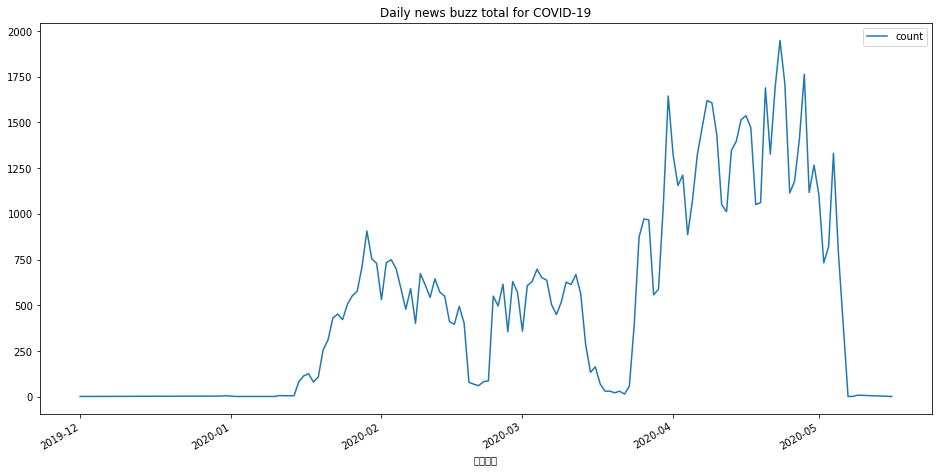

In [11]:
#		3.3.2 'COVID-19' 만 구분

# ['감염병명'] == 'COVID-19' 인 것만 선별하여 일별 뉴스 발생량 구성 

ds_ns_tp = ds_ns_tp.loc[ds_ns_tp['감염병명'] == 'COVID-19']
ds_ns_tp['게시일자'] =  ds_ns_tp['게시일자'].str[:10]
ds_ns = pd.DataFrame(ds_ns_tp.groupby('게시일자')['감염병명'].count())
ds_ns = ds_ns.loc[ds_ns.index >= '2019-10-31']
ds_ns.index = pd.to_datetime(ds_ns.index, format='%Y-%m-%d')
ds_ns = ds_ns.rename(columns={"감염병명":"count"})
ds_ns.plot(figsize=(16,8),title="Daily news buzz total for COVID-19")


In [12]:
#		3.3.3 News BERT embedding

# 실 Contents는 사용하지 않고 title만 BERT embedding 처리...
# 시간 상당히 오래 걸림, 약 1시간 30분

#Start BERT embedding for news title...81785
#Length of corpus:81785
#Complete!!
#shape of corpus_embeddings :  (81785, 768)
#length of corpus :  81785
#End... elapsed time : 1:26:13.748154

# Sentence Transformers: Multilingual Sentence Embeddings using BERT / RoBERTa / XLM-RoBERTa & Co. with PyTorch
# https://github.com/UKPLab/sentence-transformers

!pip install -U sentence-transformers

from timeit import default_timer as timer
from datetime import timedelta
import os.path
from os import path
import dill
from sentence_transformers import SentenceTransformer
import scipy.spatial

start = timer()

# embedder download...
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

print("Start BERT embedding for news title...{}".format(len(ds_ns_tp)))

# 뉴스 title만 corpus로 추출
# 기사 내용도 할수는 있으나 시간 넘 걸림...
corpus = []
for row in ds_ns_tp.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    corpus.append(title.lower())
    #print("{},{},{}".format(file_name,pub_datetime,title))

print("Length of corpus:{}".format(len(corpus)))

if path.exists("corpus_embeddings.emb"):
    print("load from corpus_embeddings file...")
    file = open("corpus_embeddings.emb", 'rb')
    corpus_embeddings = dill.load(file)
    file.close()

else:
    corpus_embeddings = embedder.encode(corpus,show_progress_bar=True)   

    print("Wait! saving corpus_embeddings...")    
    file = open("corpus_embeddings.emb", 'wb')
    dill.dump(corpus_embeddings, file)
    file.close()

print("Complete!!")

corpus_embeddings = np.asarray(corpus_embeddings)        
print("shape of corpus_embeddings : ",corpus_embeddings.shape)
print("length of corpus : ",len(corpus))

#temp_ds = cov_news #.head(10)
docv_model = {}
for i, row in enumerate(ds_ns_tp.iterrows()):
    docv_model[row[1][0]] = corpus_embeddings[i]

len(docv_model)

end = timer()

print("End... elapsed time : {}".format(timedelta(seconds=end-start)))

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 645kB 13.4MB/s 
     |████████████████████████████████| 1.0MB 54.5MB/s 
     |████████████████████████████████| 3.8MB 49.9MB/s 
     |████████████████████████████████| 890kB 46.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=aa6f75d1dadd2ace7745bc9f83d99efb0a3fd38076e75346f19a550314032bcb
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e9b90c309e8647c5faed58394b338628f87a478c4f64e0822eebdedb22991b65
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 405M/405M [00:23<00:00, 16.9MB/s]


Start BERT embedding for news title...81785


Batches:   0%|          | 1/10224 [00:00<26:26,  6.44it/s]

Length of corpus:81785


Batches: 100%|██████████| 10224/10224 [02:21<00:00, 72.41it/s]


Wait! saving corpus_embeddings...
Complete!!
shape of corpus_embeddings :  (81785, 768)
length of corpus :  81785
End... elapsed time : 0:03:22.944599


In [13]:
#		3.3.4 6 Features 추출

# News에서 6개 feature 추출
# worse feature : 코로나 상황이 더 나빠지고 있다는 뉴스
# better feature : 상황이 좋아 지고 있나는 뉴스
# block feature : 격리, 입출입 차단 강화 관련 뉴스
# premit feature : 격리 해제, 입출입 완화 관련 뉴스
# yes_korea feature : 한국에 긍정적 내용 뉴스
# no_korea feature : 한국에 부정적 내용 뉴스

# 6개 feature를 추출하기 위해, 각 특성을 나타내는 간략한 sentence를 수동으로 만들고, 이를 전체 corpus_embeddings 에서 유사한 내용의 뉴스를 추출하여
# 해당 뉴스를 유사 내용으로 간주하고 score (1-간략한 sentence와의 거리)를 할당 한다.

def searchSentence(queries,Threshold_score=0.60, Topn=0,must_has_word=[]):
    index = {}
    n = len(queries)
    query_embeddings = embedder.encode(queries)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        
        for idx, distance in results[0:len(results) if Topn==0 else Topn]:
          score = 1-distance
          if not idx in index:
            index[idx] = 0.0
          if score > Threshold_score:
              if len(must_has_word) > 0:
                  if corpus[idx].strip().find(must_has_word[0]) >= 0:
                      index[idx] += float(score/n)
              else:
                  index[idx] += float(score/n)
              #print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))
    return index

ds_ns_tp.reset_index(inplace = True, drop = True) 

# 아래 간략 sentence는 수동으로 만든것. 이것을 정교히 잘 만들면 더 높은 정합성의 Feature를 추출 할 수 있을 것. 
queries_dict = {
    'worse':([],['infected corona','infected coronavirus ','increase confirmed','increase Infections','infectious increase','confirmed case incease','deaths incease','patients incease','lack prepare','not prepared','lack medical','lack preparedness']),
    'better':([],['decrease confirmed','decrease Infections','infectious decrease','confirmed case decrease','No confirmed','No case','deaths decrease','patients decrease','send supplies','order supplies','donates supplies','gives supplies','situation stability','situation stable','remains stable']),
    'block':([],['immigrants block','immigrants restrict','immigration block','immigration restrict','entrants block','entrants restrict','entry block','entry restrict','tourist block','tourist restrict','tourist Isolation','traveler block','traveler restrict','traveler Isolation','immigrants quarantine','entrants quarantine','entry quarantine','tourist quarantine','reinforce quarantine','reinforce diagnosis']),
    'permit':([],['immigrants permit','immigrants ease','immigration permit','immigration ease','entrants permit','entrants ease','entry permit','entry ease','tourist permit','tourist ease','release tourist ','traveler permit','release quarantine','release quarantine']),
    'yes_korea':(['korea'],['korea decrease confirmed','korea decrease Infections','korea infectious decrease','korea confirmed case decrease','korea No confirmed','korea No case','korea deaths decrease','korea patients decrease','korea send supplies','korea order supplies','korea donates supplies','korea gives supplies','korea situation stability','korea situation stable','korea remains stable','korea immigrants permit','korea immigrants ease','korea immigration permit','korea immigration ease','korea entrants permit','korea entrants ease','korea entry permit','korea entry ease','korea tourist permit','korea tourist ease','korea release tourist ','korea traveler permit','korea release quarantine','korea release quarantine']),
    'no_korea':(['korea'],['korea infected corona','korea infected coronavirus ','korea increase confirmed','korea increase Infections','korea infectious increase','korea confirmed case incease','korea deaths incease','korea patients incease','korea lack prepare','korea not prepared','korea lack medical','korea lack preparedness','korea immigrants block','korea immigrants restrict','korea immigration block','korea immigration restrict','korea entrants block','korea entrants restrict','korea entry block','korea entry restrict','korea tourist block','korea tourist restrict','korea tourist Isolation','korea traveler block','korea traveler restrict','korea traveler Isolation','korea immigrants quarantine','korea entrants quarantine','korea entry quarantine','korea tourist quarantine','korea reinforce quarantine','korea reinforce diagnosis'])
}
# Query sentences:

for query_key in queries_dict.keys():
  ds_ns_tp[query_key] = 0
  idxs = searchSentence(queries_dict[query_key][1],Threshold_score = 0.6,must_has_word=queries_dict[query_key][0])
  print('{} result rows:{} query count:{}'.format(query_key,len(idxs),len(queries_dict[query_key][1])))
  ds_ns_tp.loc[list(idxs.keys()),query_key] = list(idxs.values())

ds_ns_tp[['게시일자','worse','better','block','permit','yes_korea','no_korea','제목']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


worse result rows:81785 query count:12


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


better result rows:81785 query count:15
block result rows:81785 query count:20
permit result rows:81785 query count:14
yes_korea result rows:81785 query count:29
no_korea result rows:81785 query count:32


,게시일자,worse,better,block,permit,yes_korea,no_korea,제목
0,2020-01-25,0.054946,0.0,0.0,0.0,0.0,0.0,Rwanda Public Notice on Novel Coronavirus
1,2020-01-31,0.000000,0.0,0.0,0.0,0.0,0.0,WHO ramps up preparedness for novel coronaviru...
2,2020-02-01,0.051934,0.0,0.0,0.0,0.0,0.0,Rwanda hastens safety measures against novel c...
3,2020-02-02,0.000000,0.0,0.0,0.0,0.0,0.0,Eritrea Strengthening Preparedness to 2019 nov...
4,2020-02-04,0.000000,0.0,0.0,0.0,0.0,0.0,WHO supports Botswana’s preparedness and respo...
...,...,...,...,...,...,...,...,...
81780,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,"Spotlight: Europeans restart ""normal"" life in ..."
81781,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Russia's top spacecraft designer reportedly di...
81782,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Glimpse of a world under pandemic
81783,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Chinese clinical experience on COVID-19 treatm...


In [14]:
#		3.3.5 일별 6 Features 그룹핑

# 6개 feature를 일자 기준 하나의 dataframe으로 join

cov_1 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['worse'].sum())
cov_2 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['better'].sum())
cov_3 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['block'].sum())
cov_4 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['permit'].sum())
cov_5 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['yes_korea'].sum())
cov_6 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['no_korea'].sum())

ds_ns_cov = ds_ns.join(cov_1).join(cov_2).join(cov_3).join(cov_4).join(cov_5).join(cov_6)
ds_ns_cov

,count,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,,
2019-12-01,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-14,2,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-30,3,0.058952,0.000000,0.000000,0.000000,0.0,0.0
2019-12-31,5,0.170601,0.000000,0.000000,0.000000,0.0,0.0
2020-01-02,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-05,793,5.810915,0.516218,0.435219,0.223337,0.0,0.0
2020-05-07,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-05-08,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

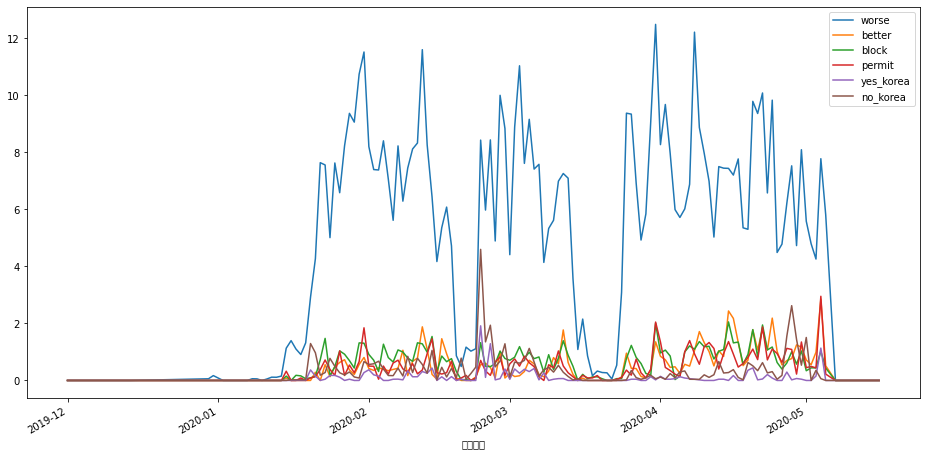

In [15]:
# 추출된 feature의 추세 확인
ds_ns_cov.plot(y=['worse','better','block','permit','yes_korea','no_korea'],figsize=(16,8))

,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,
2019-12-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-14,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-30,0.019651,0.000000,0.000000,0.000000,0.0,0.0
2019-12-31,0.034120,0.000000,0.000000,0.000000,0.0,0.0
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...
2020-05-05,0.007328,0.000651,0.000549,0.000282,0.0,0.0
2020-05-07,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-05-08,0.000000,0.000000,0.000000,0.000000,0.0,0.0


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

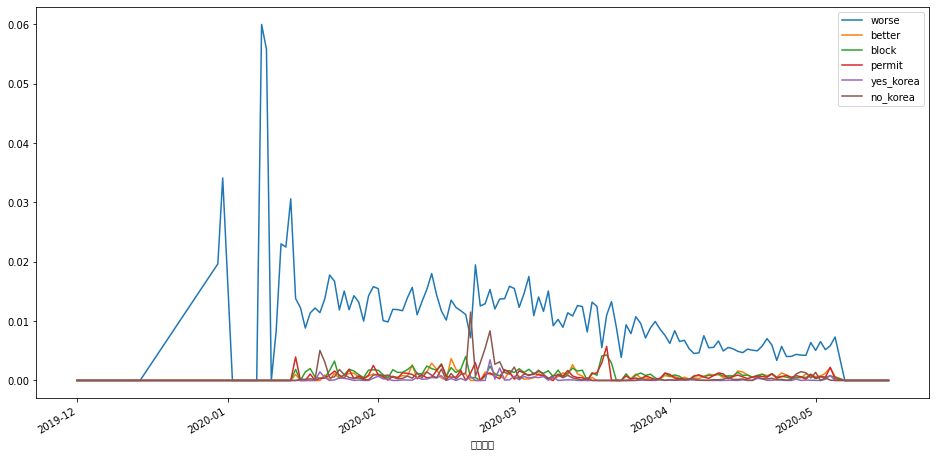

In [16]:
#		3.3.6 6 Features Normalization

ds_ns_cov_n = pd.DataFrame({'worse':ds_ns_cov['worse']/ds_ns_cov['count']})
ds_ns_cov_n["better"] = ds_ns_cov['better']/ds_ns_cov['count']
ds_ns_cov_n["block"] = ds_ns_cov['block']/ds_ns_cov['count']
ds_ns_cov_n["permit"] = ds_ns_cov['permit']/ds_ns_cov['count']
ds_ns_cov_n["yes_korea"] = ds_ns_cov['yes_korea']/ds_ns_cov['count']
ds_ns_cov_n["no_korea"] = ds_ns_cov['no_korea']/ds_ns_cov['count']
# Normalization 한 feature의 추세 확인
ds_ns_cov_n.plot(figsize=(16,8))
ds_ns_cov_n

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

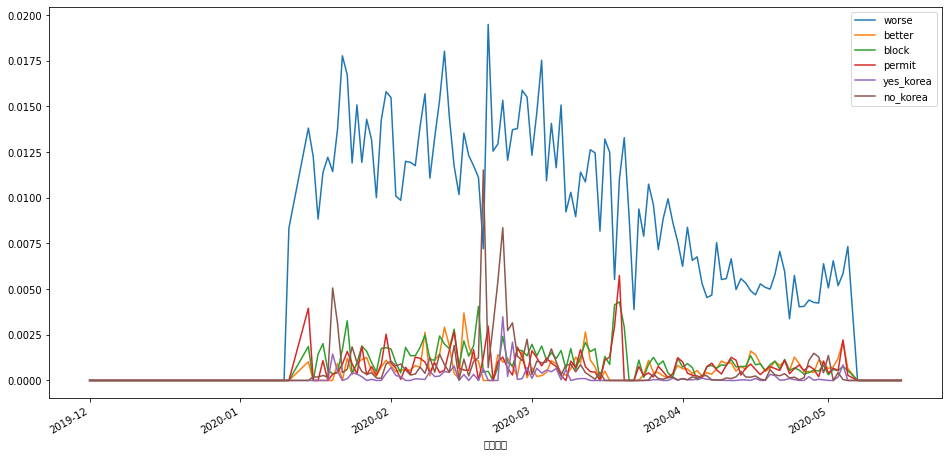

In [17]:
#		3.3.7 Outlier 제거

# worse 성분의 outlier filtering
ds_ns_cov_n_f = ds_ns_cov_n[ds_ns_cov_n["worse"] < 0.0195]
ds_ns_cov_n_f.plot(figsize=(16,8))

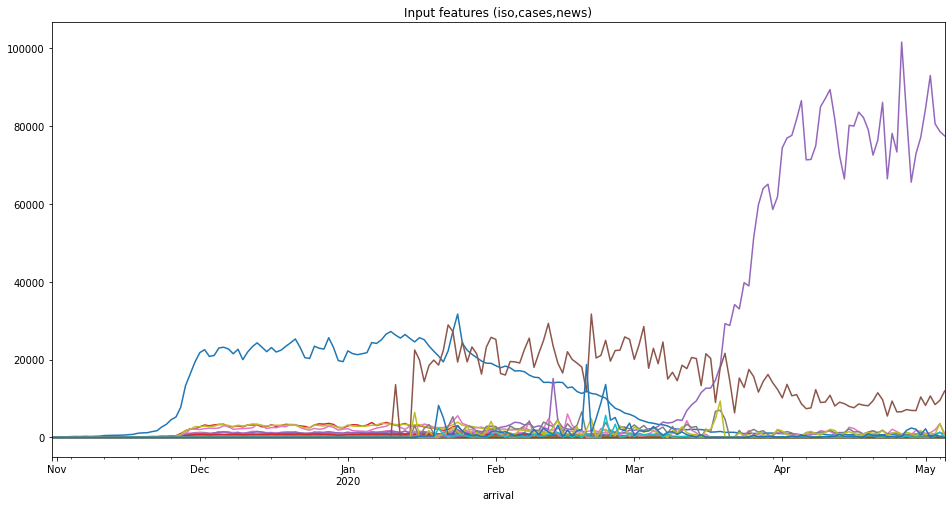

In [18]:
#	3.4 전체 Dataset 구성


ds_ns_cov_n_f_s = (ds_ns_cov_n_f / np.max(ds_ns_cov_n_f.max())) * np.max(ds_y.max())
ds_y_iso_cov_ns = ds_y_iso_cov.join(ds_ns_cov_n_f_s).fillna(0)
ds_y_iso_cov_ns.plot(legend=False,figsize=(16,8),title='Input features (iso,cases,news)')

In [81]:
# Dataset 전처리 완료!!!!!!!!!!!!!!!!
ds_x = ds_y_iso_cov_ns
ds_test_x = ds_y_iso_cov_ns.iloc[0:len(ds_y_iso_cov_ns)-15,:]
ds_test_y = ds_y.iloc[0:len(ds_y)-15,:]
ar_test_pred_y = np.asarray(ds_y.iloc[len(ds_y)-15:len(ds_y),:])

max = np.max(ds_x.max())

print('ds_x shape:',ds_x.shape)
print('ds_y shape:',ds_y.shape)
print('ds_test_x shape:',ds_test_x.shape)
print('ds_test_y shape:',ds_test_y.shape)
print('ar_test_pred_y shape:',ar_test_pred_y.shape)
print('max ds_x:',max)

result_talbe = []


ds_x shape: (188, 181)
ds_y shape: (188, 1)
ds_test_x shape: (173, 181)
ds_test_y shape: (173, 1)
ar_test_pred_y shape: (15, 1)
max ds_x: 101533.0


4. Timeseries deep learning model Test

	4.1 1D Convolution CNN Model Test
   
   4.1.1 30일 window, 15일 일괄 예측 Model Test

    아래 그림과 같이, 하루 180개 feature로 이후 '15일의 로밍등록자수'를 예측하는 regression 알고리즘을 적용한다.
   전체 날짜기간을 sliding window 개념으로 Scan 하면서 Time-series dataset을 형성한다. 알고리즘의 개념에서 알 수 있듯이 마지막 15일의 data는 학습할 수 없다는 단점이 있으나, 15일 이라는 기간동안 유사한 확율로 예측할 수 있다. 통상, 1,2일 후 와 같은 근시일은 예측성능이 좋으나 뒤로 갈수로 예측율이 떨어지는데 아래의 개념으로는 15일 후에도 예측성능이 상대적으로 떨어지는 것을 막을 수 있다.


![대체 텍스트](https://github.com/dolmani38/ai_corona/blob/master/img/30%EC%9D%BCWindow_15%EC%9D%BC%EC%98%88%EC%B8%A1_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%982.jpg?raw=true)



input x: (173, 181)
input y: (173, 1)
outout train_x: (129, 30, 181)
outout train_y: (129, 15)
outout predict_x: (1, 30, 181)
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 30, 128)           92800     
_________________________________________________________________
activation_71 (Activation)   (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 15, 128)           0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 15, 128)           65664     
_________________________________________________________________
activation_72 (Activation)   (None, 15, 128)           0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 7, 128)            0   

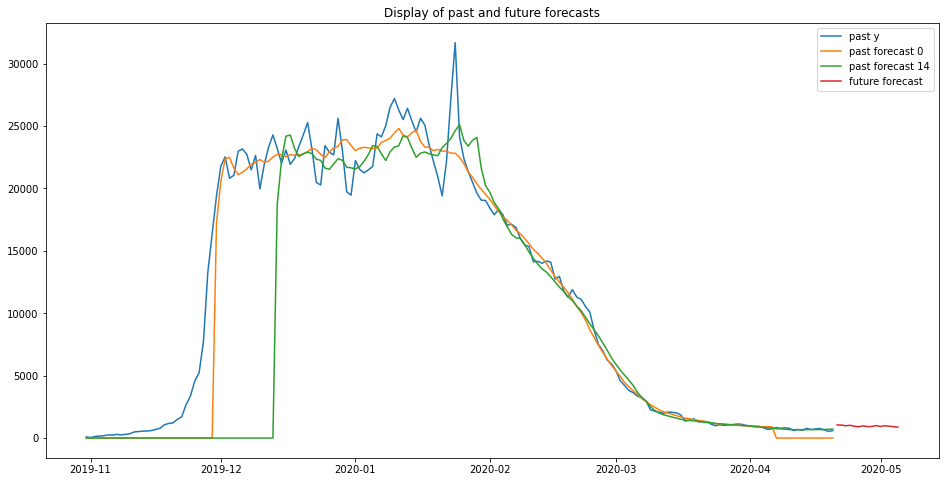

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-04-21,1053,834 ~ 1272,520.259155,3476 ~ 5303
2020-04-22,1037,829 ~ 1245,494.027435,3454 ~ 5188
2020-04-23,985,776 ~ 1194,496.405151,3235 ~ 4978
2020-04-24,1021,816 ~ 1227,488.771698,3400 ~ 5116
2020-04-25,939,759 ~ 1119,427.430878,3164 ~ 4665
2020-04-26,906,757 ~ 1055,354.298035,3155 ~ 4399
2020-04-27,979,818 ~ 1141,383.836182,3409 ~ 4756
2020-04-28,914,764 ~ 1064,356.146667,3186 ~ 4436
2020-04-29,922,751 ~ 1093,406.766724,3129 ~ 4557


In [82]:
#	4.2 1D Convolution CNN Model Test
#		4.2.1 30일 window적용, 15일 일괄 예측 Ensemble CNN Model Test


# 동일한 방법으로 ensemble 에 의해 예측, 통계적 신뢰수준을 적용하여 로밍등록자 예측을 구간추정 한다.

case = "CNN,30,15"
window = 30
forecast=15

# 학습을 위한 Dataset 추출
train_x,train_y,predict_x = create_timeseries_dataset(ds_test_x,ds_test_y,window=window,forecast=forecast)
# 학습
ensemble_model,mean_a_e,r_square = ensemble_train(train_x,train_y,ensemble_count=25,epoch=50)
# 과거 dataset으로 역예측
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
# test dataset으로 향후 예측 -> Test
predict_x_y,ensemble_predict_x_y = ensemble_predict(ensemble_model,predict_x)
# ensemble 예측에 대한 통계분석, 표준편차, 구간추정
ds_s_r = statistical_results_analysis(ensemble_predict_x_y,ds_test_y)
# ensemble 예측에 대한 표준편차
std = np.mean(ds_s_r['Standard deviation'])
print('Mean absolute error of learning:',mean_a_e)
print('R square value of learning:',r_square)
print('Standard deviation of predicted value for each model:',std)
# test dataset으로 향후 예측에 대한 MSE 
mean_s_e = mean_squared_error(ar_test_pred_y, predict_x_y[0])
print('Mean square erro with test target value:',mean_s_e)
result_talbe.append({'case':case,'mae':mean_a_e ,'r2':r_square ,'std':std,'mse':mean_s_e})
# 결과 표출...
compare_with_past_y(past_y=ds_test_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])


input x: (173, 181)
input y: (173, 181)
outout train_x: (133, 40, 181)
outout train_y: (133, 181)
outout predict_x: (1, 40, 181)
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 40, 128)           92800     
_________________________________________________________________
activation_75 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 20, 128)           65664     
_________________________________________________________________
activation_76 (Activation)   (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 10, 128)           0

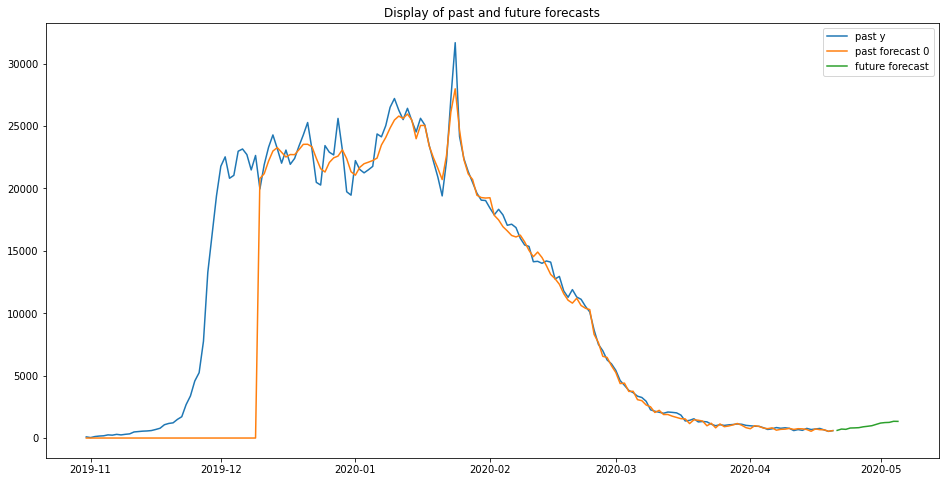

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-04-21,613,429 ~ 797,436.730713,1791 ~ 3324
2020-04-22,719,534 ~ 904,439.217346,2226 ~ 3768
2020-04-23,696,464 ~ 927,548.662964,1936 ~ 3863
2020-04-24,802,583 ~ 1021,519.847107,2430 ~ 4255
2020-04-25,813,588 ~ 1038,533.618347,2453 ~ 4326
2020-04-26,831,590 ~ 1071,571.289001,2460 ~ 4465
2020-04-27,899,623 ~ 1174,654.057556,2599 ~ 4895
2020-04-28,941,642 ~ 1239,708.424927,2677 ~ 5164
2020-04-29,988,690 ~ 1286,706.468079,2878 ~ 5358


In [83]:
#		4.2.2 40일 Window적용, 15일 재귀적 예측 Ensemble CNN Model Test

case = "CNN,40,1"
window = 40
forecast=1

# 학습을 위한 Dataset 추출
train_x,train_y,predict_x = create_timeseries_dataset(ds_test_x,ds_test_x,window=window,forecast=forecast)
# 학습
ensemble_model,mean_a_e,r_square = ensemble_train(train_x,train_y,ensemble_count=25,epoch=50)
# 과거 dataset으로 역예측
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
# test dataset으로 향후 예측 -> Test
predict_x_y,ensemble_predict_x_y = ensemble_recursive_forecast(ensemble_model,predict_x)
# ensemble 예측에 대한 통계분석, 표준편차, 구간추정
ds_s_r = statistical_results_analysis(ensemble_predict_x_y,ds_test_y)
# ensemble 예측에 대한 표준편차
std = np.mean(ds_s_r['Standard deviation'])
print('Mean absolute error of learning:',mean_a_e)
print('R square value of learning:',r_square)
print('Standard deviation of predicted value for each model:',std)
# test dataset으로 향후 예측에 대한 MSE 
mean_s_e = mean_squared_error(ar_test_pred_y, predict_x_y[0])
print('Mean square erro with test target value:',mean_s_e)
result_talbe.append({'case':case,'mae':mean_a_e ,'r2':r_square ,'std':std,'mse':mean_s_e})
# 결과 표출...
compare_with_past_y(past_y=ds_test_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])



input x: (173, 181)
input y: (173, 181)
outout train_x: (169, 4, 181)
outout train_y: (169, 181)
outout predict_x: (1, 4, 181)
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 4, 256)            92928     
_________________________________________________________________
activation_79 (Activation)   (None, 4, 256)            0         
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 2, 256)            0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 2, 256)            131328    
_________________________________________________________________
activation_80 (Activation)   (None, 2, 256)            0         
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1, 256)            0  

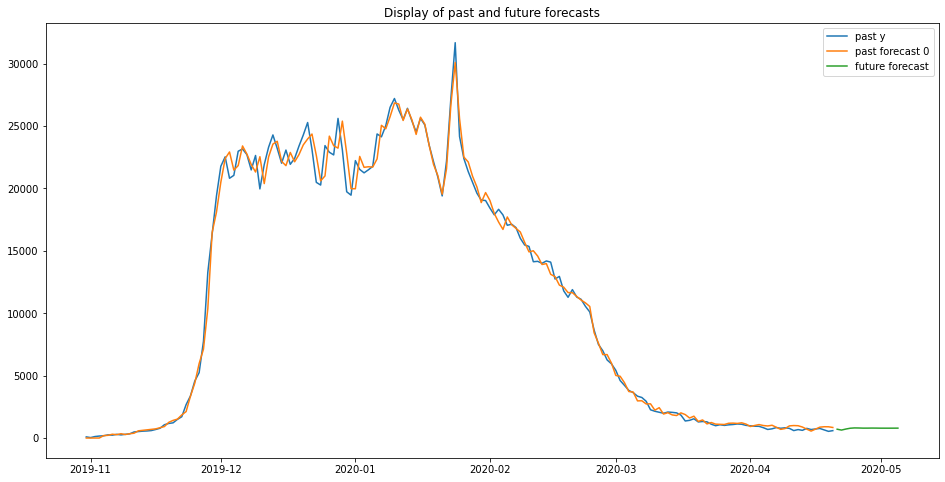

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-04-21,707,525 ~ 889,432.213470,2187 ~ 3704
2020-04-22,638,468 ~ 809,403.903656,1953 ~ 3371
2020-04-23,720,544 ~ 897,419.500824,2266 ~ 3739
2020-04-24,785,611 ~ 958,412.246185,2548 ~ 3995
2020-04-25,810,635 ~ 985,414.905579,2648 ~ 4105
2020-04-26,804,630 ~ 978,412.978424,2625 ~ 4075
2020-04-27,793,613 ~ 973,426.673767,2558 ~ 4056
2020-04-28,794,608 ~ 980,441.523987,2535 ~ 4086
2020-04-29,798,606 ~ 989,454.940796,2527 ~ 4124


In [84]:
#		4.2.3  4일 Window적용, 15일 재귀적 예측 Ensemble CNN Model Test


def create_model2(input_shape=(30, 1), output=15, metrics=['mae', r2]):
    """
    1D Covolution의 Deep Neural Network model 구성. (keras 기반)
    :param input_shape: 입력 배열 구조 예) 100,15
    :param output: forecast 기간
                    예:'15'의 경우, window를 input으로 15개(15일)의 output을 regression 한다는 의미
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return: model
    """
    import keras
    from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
    from keras.models import Sequential

    model = Sequential()
    model.add(Conv1D(256, 2, input_shape=input_shape, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(256, 2, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    #model.add(Conv1D(64, 2, padding="same"))
    #model.add(Activation('relu'))
    #model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dense(output))
    model.add(Activation('linear'))

    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)

    model.summary()

    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
    print("save to model.json")

    return model

case = "CNN,4,1"
window = 4
forecast=1

# 학습을 위한 Dataset 추출
train_x,train_y,predict_x = create_timeseries_dataset(ds_test_x,ds_test_x,window=window,forecast=forecast)
# 학습
ensemble_model,mean_a_e,r_square = ensemble_train(train_x,train_y,model_method=create_model2,ensemble_count=25,epoch=50)
# 과거 dataset으로 역예측
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
# test dataset으로 향후 예측 -> Test
predict_x_y,ensemble_predict_x_y = ensemble_recursive_forecast(ensemble_model,predict_x)
# ensemble 예측에 대한 통계분석, 표준편차, 구간추정
ds_s_r = statistical_results_analysis(ensemble_predict_x_y,ds_test_y)
# ensemble 예측에 대한 표준편차
std = np.mean(ds_s_r['Standard deviation'])
print('Mean absolute error of learning:',mean_a_e)
print('R square value of learning:',r_square)
print('Standard deviation of predicted value for each model:',std)
# test dataset으로 향후 예측에 대한 MSE 
mean_s_e = mean_squared_error(ar_test_pred_y, predict_x_y[0])
print('Mean square erro with test target value:',mean_s_e)
result_talbe.append({'case':case,'mae':mean_a_e ,'r2':r_square ,'std':std,'mse':mean_s_e})
# 결과 표출...
compare_with_past_y(past_y=ds_test_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])


In [85]:
rt = pd.DataFrame(result_talbe)
rt = rt.set_index('case')
rt

,mae,r2,std,mse
case,,,,
"CNN,30,15",1284.980835,0.661043,417.205231,153024.416305
"CNN,40,1",114.057953,0.989125,734.392867,291046.607563
"CNN,4,1",94.815842,0.984441,454.621495,62736.939551


input x: (173, 181)
input y: (173, 1)
outout train_x: (129, 30, 181)
outout train_y: (129, 15)
outout predict_x: (1, 30, 181)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 30, 256)           448512    
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_45 (Dense)             (None, 15)                1935      
_________________________________________________________________
activation_82 (Activation)   (None, 15)                0         
Total params: 647,567
Trainable params: 647,567
Non-trainable params: 0
_____________________________________________________

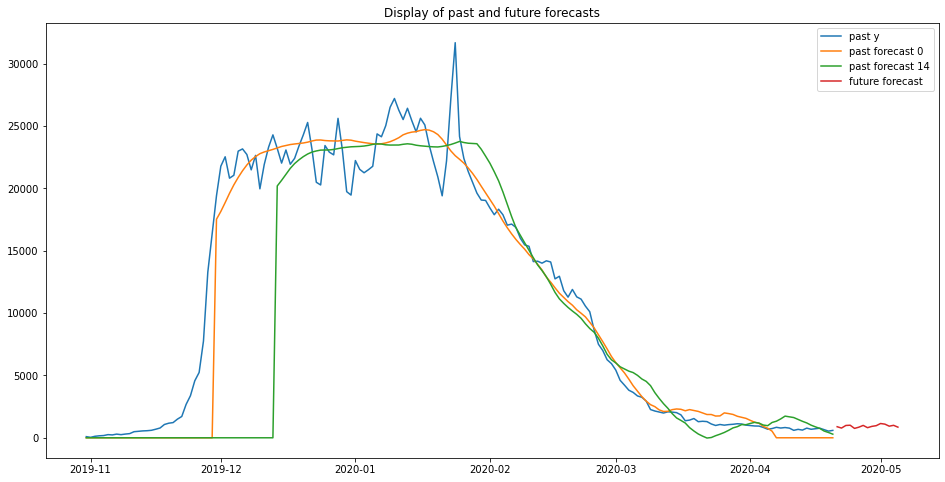

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-04-21,887,-1050 ~ 2825,4599.477539,~ 11771
2020-04-22,779,-931 ~ 2491,4062.031982,~ 10379
2020-04-23,987,-946 ~ 2921,4590.565918,~ 12173
2020-04-24,1007,-792 ~ 2808,4273.102051,~ 11700
2020-04-25,752,-978 ~ 2482,4107.899902,~ 10345
2020-04-26,850,-983 ~ 2685,4354.707031,~ 11189
2020-04-27,993,-927 ~ 2914,4560.897949,~ 12145
2020-04-28,810,-1032 ~ 2652,4374.319336,~ 11053
2020-04-29,915,-1161 ~ 2992,4930.294434,~ 12470


In [86]:
#	4.3 LSTM Model Test
#		4.3.1 30일 window, 15일 일괄 예측 Ensemble LSTM Model Test


case = "LSTM,30,15"
window = 30
forecast=15

# 학습을 위한 Dataset 추출 -> max로 나누어서 0~1사이로 Normalize한다. LSTM의 특성상, Normalize해야 성능이 나온다.
train_x,train_y,predict_x = create_timeseries_dataset(ds_test_x/max,ds_test_y/max,window=window,forecast=forecast)
# 학습
ensemble_model,mean_a_e,r_square = ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=50)
# 과거 dataset으로 역예측, *max 해서 결과 보정
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
# test dataset으로 향후 예측 -> Test, *max 해서 결과 보정
predict_x_y,ensemble_predict_x_y = ensemble_predict(ensemble_model,predict_x)
# ensemble 예측에 대한 통계분석, 표준편차, 구간추정
ds_s_r = statistical_results_analysis(ensemble_predict_x_y*max,ds_test_y)
# ensemble 예측에 대한 표준편차
std = np.mean(ds_s_r['Standard deviation'])
print('Mean absolute error of learning:',mean_a_e)
print('R square value of learning:',r_square)
print('Standard deviation of predicted value for each model:',std)
# test dataset으로 향후 예측에 대한 MSE 
mean_s_e = mean_squared_error(ar_test_pred_y, predict_x_y[0]*max)
print('Mean square erro with test target value:',mean_s_e)
#result_talbe.append({'case':case,'mae':mean_a_e ,'r2':r_square ,'std':std,'mse':mean_s_e})
# 결과 표출...
compare_with_past_y(past_y=ds_test_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])




input x: (173, 181)
input y: (173, 181)
outout train_x: (133, 40, 181)
outout train_y: (133, 181)
outout predict_x: (1, 40, 181)
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 40, 256)           448512    
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 256)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_46 (Dense)             (None, 181)               23349     
_________________________________________________________________
activation_83 (Activation)   (None, 181)               0         
Total params: 668,981
Trainable params: 668,981
Non-trainable params: 0
__________________________________________________

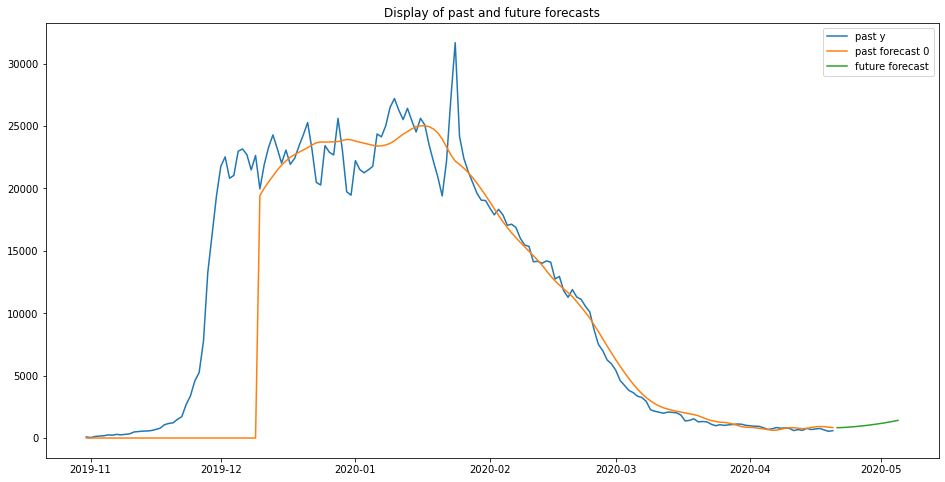

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-04-21,830,504 ~ 1157,774.591370,2102 ~ 4821
2020-04-22,839,501 ~ 1177,801.913818,2089 ~ 4905
2020-04-23,857,501 ~ 1214,845.943970,2089 ~ 5058
2020-04-24,882,502 ~ 1262,901.271973,2095 ~ 5259
2020-04-25,911,505 ~ 1317,963.886536,2104 ~ 5488
2020-04-26,945,510 ~ 1379,1031.296143,2128 ~ 5749
2020-04-27,982,518 ~ 1446,1101.584961,2160 ~ 6028
2020-04-28,1021,527 ~ 1516,1173.447754,2198 ~ 6317
2020-04-29,1066,541 ~ 1591,1246.687500,2255 ~ 6632


In [87]:
#		4.3.2 40일 Window적용, 15일 재귀적 예측 Ensemble LSTM Model Test


case = "LSTM,40,1"
window = 40
forecast=1

# 학습을 위한 Dataset 추출 -> max로 나누어서 0~1사이로 Normalize한다. LSTM의 특성상, Normalize해야 성능이 나온다.
train_x,train_y,predict_x = create_timeseries_dataset(ds_test_x/max,ds_test_x/max,window=window,forecast=forecast)
# 학습
ensemble_model,mean_a_e,r_square = ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=50)
# 과거 dataset으로 역예측
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
# test dataset으로 향후 예측 -> Test
predict_x_y,ensemble_predict_x_y = ensemble_recursive_forecast(ensemble_model,predict_x)
# ensemble 예측에 대한 통계분석, 표준편차, 구간추정
ds_s_r = statistical_results_analysis(ensemble_predict_x_y*max,ds_test_y)
# ensemble 예측에 대한 표준편차
std = np.mean(ds_s_r['Standard deviation'])
print('Mean absolute error of learning:',mean_a_e)
print('R square value of learning:',r_square)
print('Standard deviation of predicted value for each model:',std)
# test dataset으로 향후 예측에 대한 MSE 
mean_s_e = mean_squared_error(ar_test_pred_y, predict_x_y[0]*max)
print('Mean square erro with test target value:',mean_s_e)
result_talbe.append({'case':case,'mae':mean_a_e ,'r2':r_square ,'std':std,'mse':mean_s_e})
# 결과 표출...
compare_with_past_y(past_y=ds_test_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])


input x: (173, 181)
input y: (173, 181)
outout train_x: (169, 4, 181)
outout train_y: (169, 181)
outout predict_x: (1, 4, 181)
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 4, 256)            448512    
_________________________________________________________________
dropout_11 (Dropout)         (None, 4, 256)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_47 (Dense)             (None, 181)               23349     
_________________________________________________________________
activation_84 (Activation)   (None, 181)               0         
Total params: 668,981
Trainable params: 668,981
Non-trainable params: 0
____________________________________________________

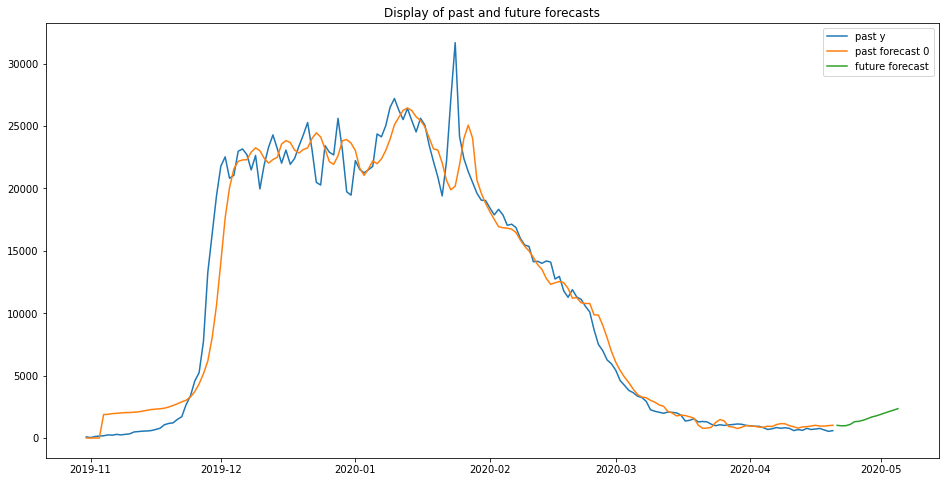

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-04-21,1014,745 ~ 1284,638.707153,3107 ~ 5350
2020-04-22,980,680 ~ 1279,711.434143,2835 ~ 5332
2020-04-23,991,631 ~ 1352,854.782959,2632 ~ 5633
2020-04-24,1091,644 ~ 1538,1061.394653,2683 ~ 6410
2020-04-25,1307,742 ~ 1872,1341.907471,3092 ~ 7803
2020-04-26,1341,715 ~ 1967,1485.331909,2982 ~ 8197
2020-04-27,1426,724 ~ 2129,1667.560669,3017 ~ 8872
2020-04-28,1553,768 ~ 2339,1865.446411,3200 ~ 9749
2020-04-29,1690,822 ~ 2557,2059.203857,3428 ~ 10657


In [88]:

#		4.3.3   4일 Window적용, 15일 재귀적 예측 Ensemble LSTM Model Test


case = "LSTM,4,1"
window = 4
forecast=1

# 학습을 위한 Dataset 추출 -> max로 나누어서 0~1사이로 Normalize한다. LSTM의 특성상, Normalize해야 성능이 나온다.
train_x,train_y,predict_x = create_timeseries_dataset(ds_test_x/max,ds_test_x/max,window=window,forecast=forecast)
# 학습
ensemble_model,mean_a_e,r_square = ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=50)
# 과거 dataset으로 역예측
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
# test dataset으로 향후 예측 -> Test
predict_x_y,ensemble_predict_x_y = ensemble_recursive_forecast(ensemble_model,predict_x)
# ensemble 예측에 대한 통계분석, 표준편차, 구간추정
ds_s_r = statistical_results_analysis(ensemble_predict_x_y*max,ds_test_y)
# ensemble 예측에 대한 표준편차
std = np.mean(ds_s_r['Standard deviation'])
print('Mean absolute error of learning:',mean_a_e)
print('R square value of learning:',r_square)
print('Standard deviation of predicted value for each model:',std)
# test dataset으로 향후 예측에 대한 MSE 
mean_s_e = mean_squared_error(ar_test_pred_y, predict_x_y[0]*max)
print('Mean square erro with test target value:',mean_s_e)
result_talbe.append({'case':case,'mae':mean_a_e ,'r2':r_square ,'std':std,'mse':mean_s_e})
# 결과 표출...
compare_with_past_y(past_y=ds_test_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])


In [89]:
rt = pd.DataFrame(result_talbe)
rt

,case,mae,r2,std,mse
0,"CNN,30,15",1284.980835,0.661043,417.205231,1.530244e+05
1,"CNN,40,1",114.057953,0.989125,734.392867,2.910466e+05
2,"CNN,4,1",94.815842,0.984441,454.621495,6.273694e+04
3,"LSTM,40,1",0.002279,0.960639,1192.958228,3.254197e+05
4,"LSTM,4,1",0.001926,0.958160,1839.056490,1.336622e+06


input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           92800     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 128)           65664     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 128)            0       

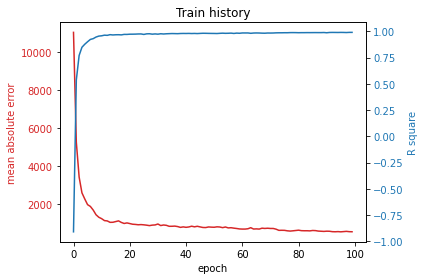

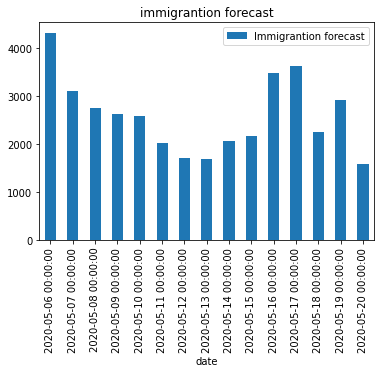

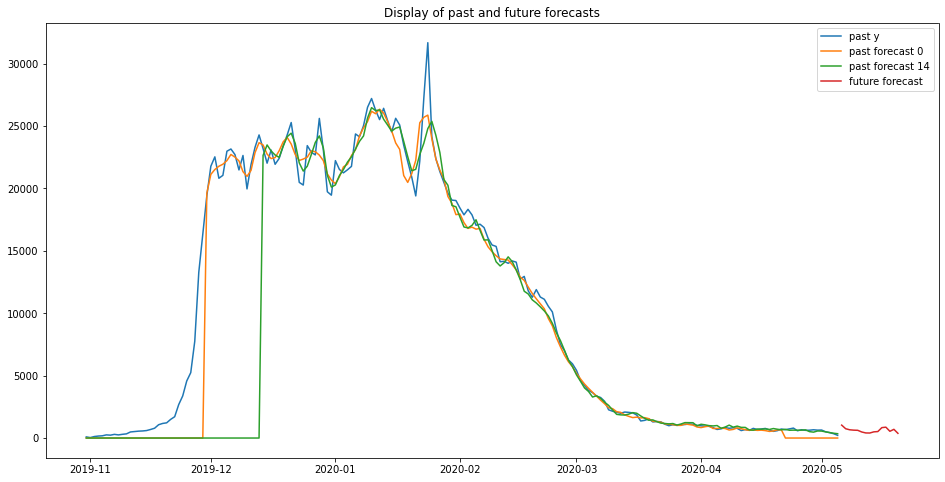

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,1035.776367,4315
2020-05-07,744.735840,3103
2020-05-08,660.336914,2751
2020-05-09,631.250732,2630
2020-05-10,619.296448,2580
2020-05-11,484.536438,2018
2020-05-12,407.448090,1697
2020-05-13,402.029846,1675
2020-05-14,494.866333,2061


In [23]:
#4. Timeseries deep learning model Test
#	4.1 1D Convolution CNN Model Test
#		4.1.1 30일 window, 15일 일괄 예측 CNN Model Test


# 30일간의 Data를 통해, 향후 15일을 1D Convolution Regression을 사용하여 예측.

window = 30
forecast=15

train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y,window=window,forecast=forecast)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)
train_x_y,train_x_y.shape
predict_x_y = model.predict(predict_x)
ds_s_r = display_result(predict_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecate'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r



input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 30, 128)           92800     
_________________________________________________________________
activation_9 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 15, 128)           65664     
_________________________________________________________________
activation_10 (Activation)   (None, 15, 128)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 7, 128)            0       

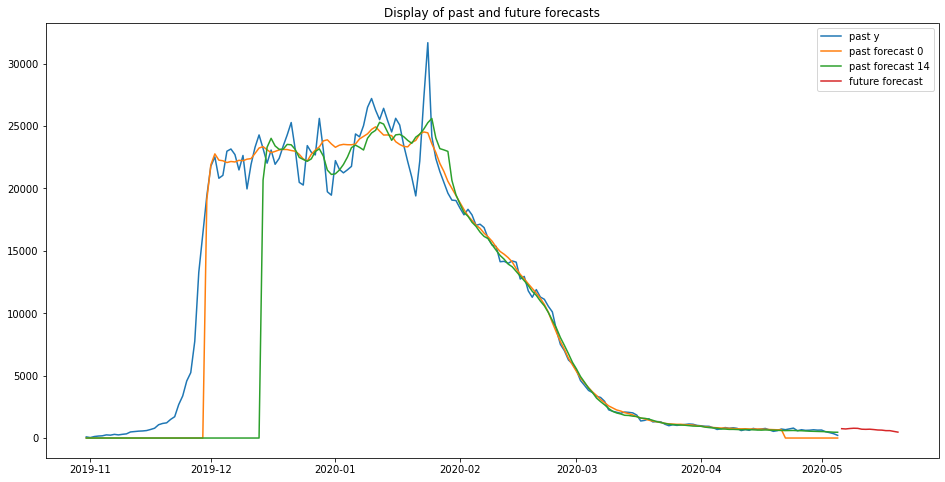

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,749,633 ~ 865,275.847290,2639 ~ 3607
2020-05-07,727,610 ~ 844,277.613525,2544 ~ 3519
2020-05-08,762,655 ~ 869,253.754272,2732 ~ 3623
2020-05-09,785,684 ~ 887,241.395126,2850 ~ 3697
2020-05-10,775,659 ~ 892,276.374939,2748 ~ 3718
2020-05-11,707,604 ~ 811,246.020401,2518 ~ 3381
2020-05-12,697,584 ~ 810,267.367981,2436 ~ 3375
2020-05-13,708,611 ~ 805,230.272614,2546 ~ 3355
2020-05-14,679,589 ~ 769,213.872025,2455 ~ 3206


In [26]:
#		4.1.2 30일 window, 15일 일괄 예측 Ensemble CNN Model Test


# 동일한 방법으로 ensemble 에 의해 예측, 통계적 신뢰수준을 적용하여 로밍등록자 예측을 구간추정 한다.

window = 30
forecast=15

train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y,window=window,forecast=forecast)

ensemble_model = ensemble_train(train_x,train_y,ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
predict_x_y,ensemble_predict_x_y = ensemble_predict(ensemble_model,predict_x)
ds_s_r = statistical_results_analysis(ensemble_predict_x_y,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])


4.1.3 1일 예측 후 15일 재귀적 예측 Model Test

아래 그림과 같이, 40일간의 180여개 feature로 그 다음 1일의 180여개 feature에 대해 regression을 적용하는 알고리즘이다. sliding window형태로 전체 기간을  scan하면서 Time-series data를 생성한다. 마지막 1일만 학습하지 못하므로 근시일의 예측력은 좋으나, 예측값을 다시 입력값으로 사용하므로 장기간의 예측력은 떨어질 수 있다. 

이번 테스트에서는 40일 window, 4일 window 2가지를 테스트 한다.


![대체 텍스트](https://github.com/dolmani38/ai_corona/blob/master/img/40%EC%9D%BCWindow_15%EC%9D%BC%EC%9E%AC%EA%B7%80%EC%98%88%EC%B8%A1_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%982.jpg?raw=true)

input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout test_x: (1, 40, 181)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 40, 128)           92800     
_________________________________________________________________
activation_13 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 20, 128)           65664     
_________________________________________________________________
activation_14 (Activation)   (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 10, 128)           0    

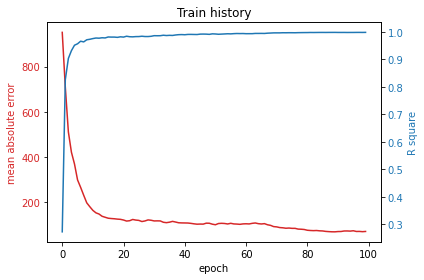

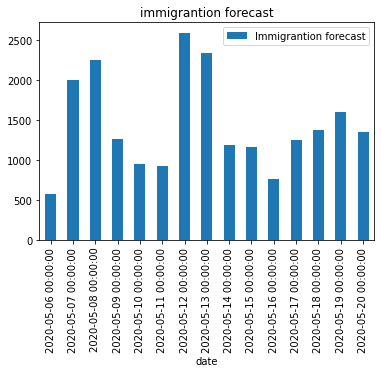

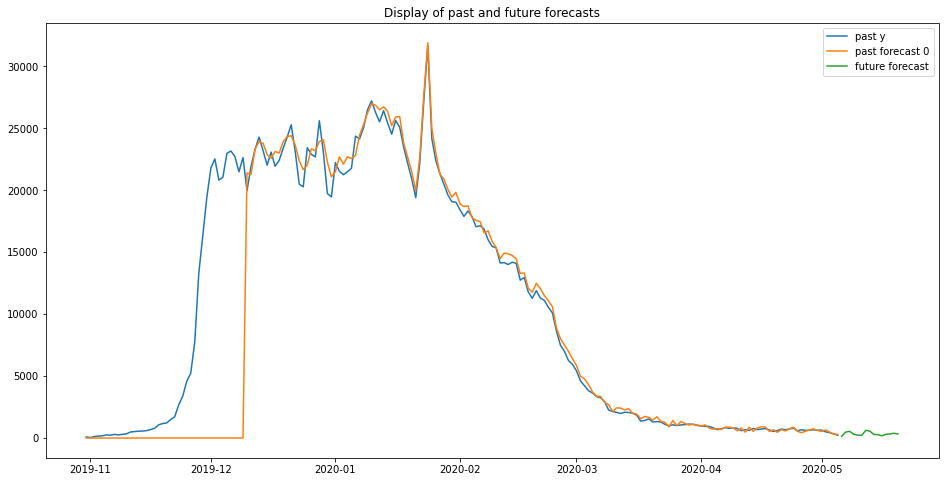

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,137.111679,571
2020-05-07,478.322662,1993
2020-05-08,539.558472,2248
2020-05-09,303.632172,1265
2020-05-10,229.194748,954
2020-05-11,221.133957,921
2020-05-12,621.765442,2590
2020-05-13,561.337952,2338
2020-05-14,285.882812,1191


In [27]:
#		4.1.3 1일 예측 후 15일 재귀적 예측 CNN Model Test
#			4.1.3.1 40일 Window적용, 15일 재귀적 예측 CNN Model Test

# window = 40, forecast=1 로, 하루 앞을 예측하고 output을 재귀적으로 입력하여 15일까지를 예측한다.
#이렇게 하기 위해서는 trainset에서 y값이 x값과 같아야 한다.

window = 40
forecast=1
train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y_iso_cov_ns,window=window, forecast=forecast)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)
predict_x_y = recursive_forecast(model,predict_x)
ds_s_r = display_result(predict_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y,forecast_y= ds_s_r['Roaming register forecate'], comp_index=[0],window=window, forecast=forecast)
ds_s_r

In [51]:
#		4.1.4 1일 예측 후 15일 재귀적 예측 Ensemble CNN Model Test
#			4.1.4.1 40일 Window적용, 15일 재귀적 예측 Ensemble CNN Model Test



window = 40
forecast=1
train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y_iso_cov_ns,window=window, forecast=forecast)

ensemble_model = ensemble_train(train_x,train_y,ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
predict_x_y,ensemble_predict_x_y = ensemble_recursive_forecast(ensemble_model,predict_x)
ds_s_r = statistical_results_analysis(ensemble_predict_x_y,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])

input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout predict_x: (1, 40, 181)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 40, 128)           92800     
_________________________________________________________________
activation_37 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 20, 128)           65664     
_________________________________________________________________
activation_38 (Activation)   (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 10, 128)           0

KeyboardInterrupt: ignored

input x: (188, 181)
input y: (188, 181)
outout train_x: (184, 4, 181)
outout train_y: (184, 181)
outout predict_x: (1, 4, 181)
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 4, 256)            92928     
_________________________________________________________________
activation_105 (Activation)  (None, 4, 256)            0         
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 2, 256)            0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 2, 256)            131328    
_________________________________________________________________
activation_106 (Activation)  (None, 2, 256)            0         
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 1, 256)            0  

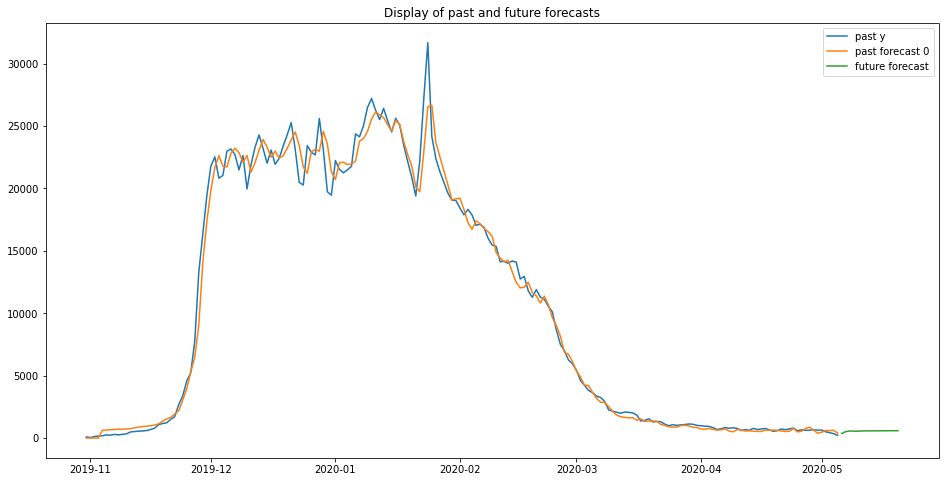

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,359,192 ~ 525,396.088715,801 ~ 2191
2020-05-07,510,360 ~ 660,355.692902,1501 ~ 2750
2020-05-08,567,400 ~ 734,396.951385,1668 ~ 3062
2020-05-09,554,374 ~ 734,426.363342,1561 ~ 3058
2020-05-10,548,360 ~ 737,447.700073,1500 ~ 3072
2020-05-11,564,371 ~ 758,459.356598,1547 ~ 3160
2020-05-12,574,376 ~ 772,469.097168,1569 ~ 3216
2020-05-13,576,374 ~ 778,478.895142,1562 ~ 3243
2020-05-14,575,370 ~ 779,485.953339,1543 ~ 3249


In [67]:
#     4.1.4.2 4일 Window적용, 15일 재귀적 예측 Ensemble CNN Model Test


def create_model2(input_shape=(30, 1), output=15, metrics=['mae', r2]):
    """
    1D Covolution의 Deep Neural Network model 구성. (keras 기반)
    :param input_shape: 입력 배열 구조 예) 100,15
    :param output: forecast 기간
                    예:'15'의 경우, window를 input으로 15개(15일)의 output을 regression 한다는 의미
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return: model
    """
    import keras
    from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
    from keras.models import Sequential

    model = Sequential()
    model.add(Conv1D(256, 2, input_shape=input_shape, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(256, 2, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    #model.add(Conv1D(64, 2, padding="same"))
    #model.add(Activation('relu'))
    #model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dense(output))
    model.add(Activation('linear'))

    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)

    model.summary()

    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
    print("save to model.json")

    return model

window = 4
forecast=1

max = np.max(ds_y_iso_cov_ns.max())

train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y_iso_cov_ns/max,window=window, forecast=forecast)

ensemble_model = ensemble_train(train_x,train_y,model_method=create_model2, ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
predict_x_y,ensemble_predict_x_y = ensemble_recursive_forecast(ensemble_model,predict_x)
ds_s_r = statistical_results_analysis(ensemble_predict_x_y*max,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])

input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout predict_x: (1, 30, 181)
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 256)           448512    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_39 (Dense)             (None, 15)                1935      
_________________________________________________________________
activation_84 (Activation)   (None, 15)                0         
Total params: 647,567
Trainable params: 647,567
Non-trainable params: 0
_____________________________________________________

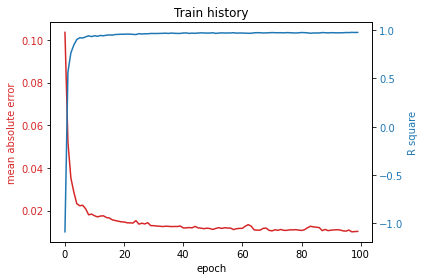

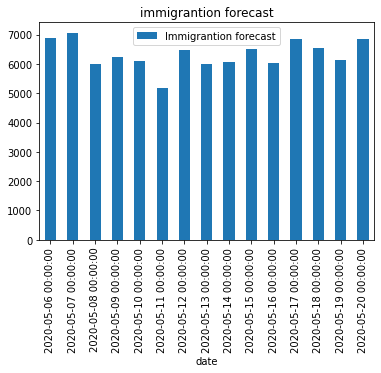

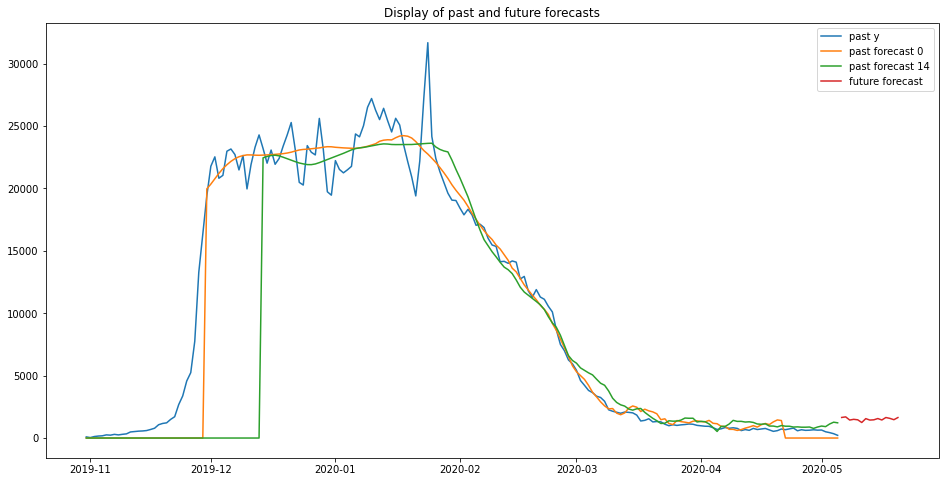

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,1649.090942,6871
2020-05-07,1695.334351,7063
2020-05-08,1441.294922,6005
2020-05-09,1499.599121,6248
2020-05-10,1460.363892,6084
2020-05-11,1245.102417,5187
2020-05-12,1556.053711,6483
2020-05-13,1439.779297,5999
2020-05-14,1459.503174,6081


In [51]:
#	4.2 LSTM Model Test
#		4.2.1 30일 window, 15일 일괄 예측 LSTM Model Test

# 30일간의 Data를 통해, 향후 15일을 LSTM을 사용하여 예측.

window = 30
forecast=15

max = np.max(ds_y_iso_cov_ns.max())

train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y/max,window=window,forecast=forecast)
model = create_lstm_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)  * max
train_x_y,train_x_y.shape
predict_x_y = model.predict(predict_x)  * max
ds_s_r = display_result(predict_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecate'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r


In [67]:
#		4.2.2 30일 window, 15일 일괄 예측 Ensemble LSTM Model Test

window = 30
forecast=15

max = np.max(ds_y_iso_cov_ns.max())
train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y/max,window=window,forecast=forecast)
ensemble_model = ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x) 
predict_x_y,ensemble_predict_x_y = ensemble_predict(ensemble_model,predict_x)
ds_s_r = statistical_results_analysis(ensemble_predict_x_y*max,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])


input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout predict_x: (1, 30, 181)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 256)           448512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_32 (Dense)             (None, 15)                1935      
_________________________________________________________________
activation_64 (Activation)   (None, 15)                0         
Total params: 647,567
Trainable params: 647,567
Non-trainable params: 0
_____________________________________________________

KeyboardInterrupt: ignored

input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout predict_x: (1, 40, 181)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 40, 256)           448512    
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_40 (Dense)             (None, 181)               23349     
_________________________________________________________________
activation_85 (Activation)   (None, 181)               0         
Total params: 668,981
Trainable params: 668,981
Non-trainable params: 0
__________________________________________________

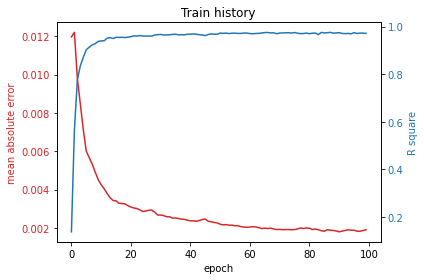

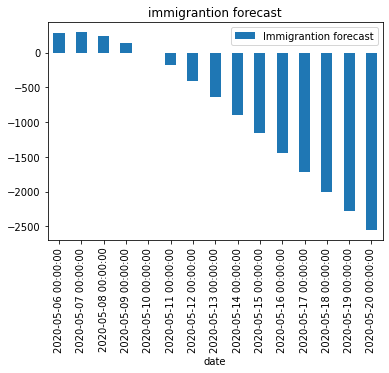

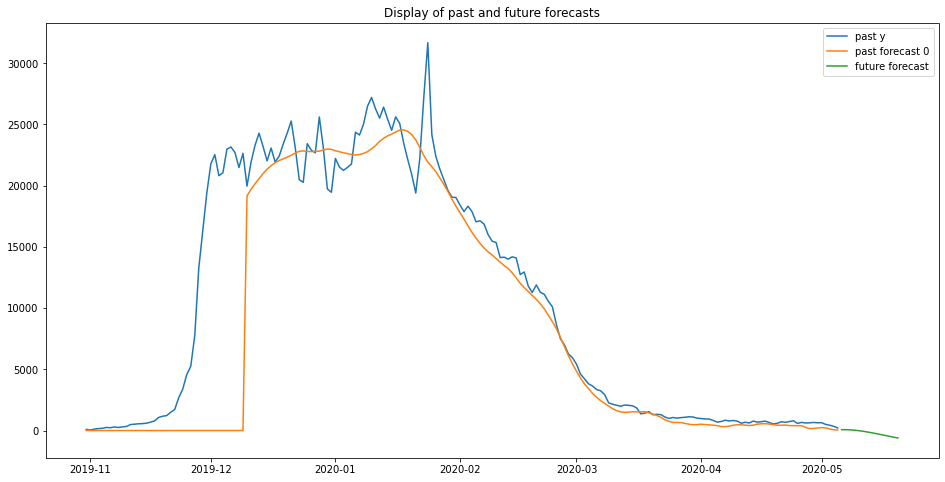

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,68.651299,286
2020-05-07,70.537773,293
2020-05-08,57.890942,241
2020-05-09,33.408417,139
2020-05-10,-0.824185,-3
2020-05-11,-44.472313,-185
2020-05-12,-96.717834,-402
2020-05-13,-153.503174,-639
2020-05-14,-215.003479,-895


In [52]:
#		4.2.3 1일 예측 후 15일 재귀적 예측 LSTM Model Test
#			4.1.3.1 40일 Window적용, 15일 재귀적 예측 LSTM Model Test

# window = 40, forecast=1 로, 하루 앞을 예측하고 output을 재귀적으로 입력하여 15일까지를 예측한다.
#이렇게 하기 위해서는 trainset에서 y값이 x값과 같아야 한다.

window = 40
forecast=1
max = np.max(ds_y_iso_cov_ns.max())

train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y_iso_cov_ns/max,window=window, forecast=forecast)
model = create_lstm_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)*max
predict_x_y = recursive_forecast(model,predict_x)*max
ds_s_r = display_result(predict_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y,forecast_y= ds_s_r['Roaming register forecate'], comp_index=[0],window=window, forecast=forecast)
ds_s_r

input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout predict_x: (1, 40, 181)
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 40, 256)           448512    
_________________________________________________________________
dropout_22 (Dropout)         (None, 40, 256)           0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_64 (Dense)             (None, 181)               23349     
_________________________________________________________________
activation_116 (Activation)  (None, 181)               0         
Total params: 668,981
Trainable params: 668,981
Non-trainable params: 0
__________________________________________________

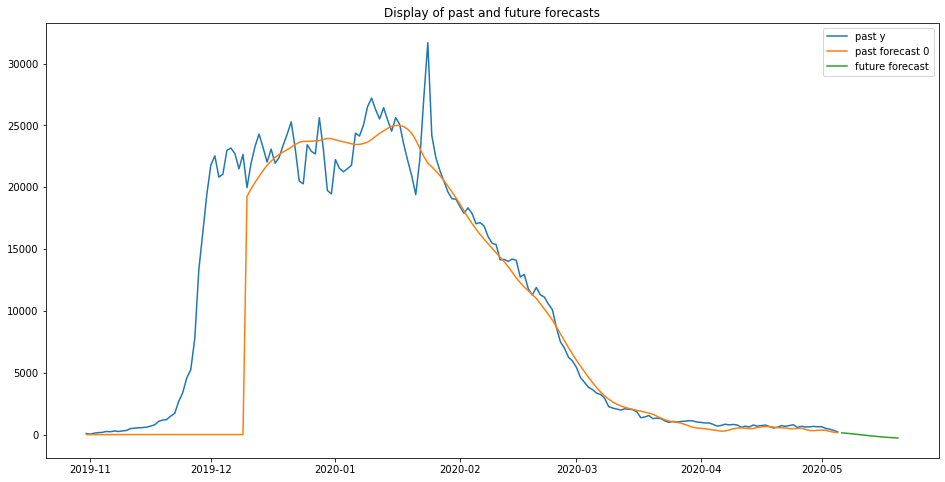

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,139,-136 ~ 416,656.756348,~ 1735
2020-05-07,115,-169 ~ 399,674.775513,~ 1663
2020-05-08,84,-211 ~ 380,702.704529,~ 1586
2020-05-09,50,-260 ~ 361,738.375305,~ 1506
2020-05-10,13,-314 ~ 342,779.756226,~ 1426
2020-05-11,-23,-370 ~ 324,824.804321,~ 1350
2020-05-12,-59,-427 ~ 307,871.980835,~ 1281
2020-05-13,-94,-481 ~ 293,920.253235,~ 1222
2020-05-14,-127,-535 ~ 280,968.795959,~ 1170


In [74]:
#		4.2.4 1일 예측 후 15일 재귀적 예측 Ensemble LSTM Model Test
#			4.1.4.1 40일 Window적용, 15일 재귀적 예측 Ensemble LSTM Model Test

window = 40
forecast=1

max = np.max(ds_y_iso_cov_ns.max())

train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y_iso_cov_ns/max,window=window, forecast=forecast)

ensemble_model = ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
predict_x_y,ensemble_predict_x_y = ensemble_recursive_forecast(ensemble_model,predict_x)
ds_s_r = statistical_results_analysis(ensemble_predict_x_y*max,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])

input x: (188, 181)
input y: (188, 181)
outout train_x: (184, 4, 181)
outout train_y: (184, 181)
outout predict_x: (1, 4, 181)
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 4, 256)            448512    
_________________________________________________________________
dropout_21 (Dropout)         (None, 4, 256)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_61 (Dense)             (None, 181)               23349     
_________________________________________________________________
activation_111 (Activation)  (None, 181)               0         
Total params: 668,981
Trainable params: 668,981
Non-trainable params: 0
____________________________________________________

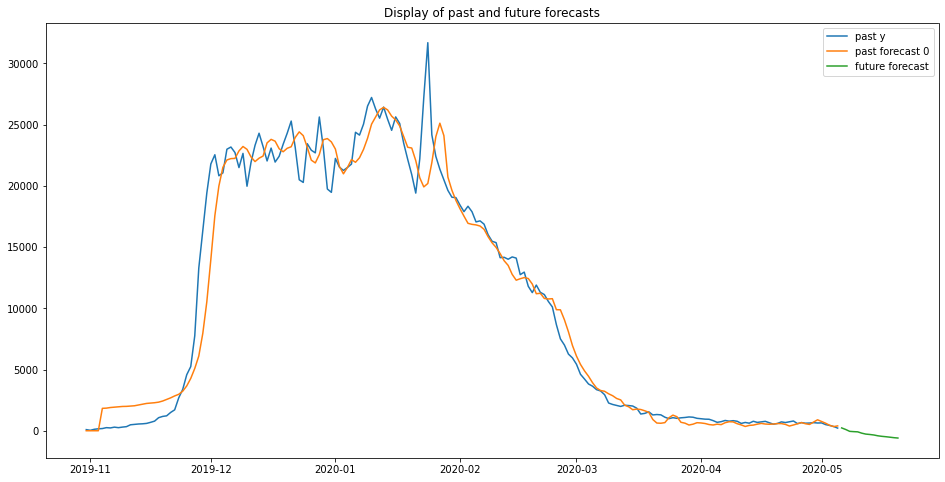

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,230,68 ~ 392,384.727509,285 ~ 1635
2020-05-07,103,-66 ~ 274,403.876831,~ 1142
2020-05-08,-50,-260 ~ 158,497.290710,~ 662
2020-05-09,-73,-337 ~ 191,627.201843,~ 795
2020-05-10,-90,-429 ~ 247,803.503479,~ 1033
2020-05-11,-198,-572 ~ 174,886.386108,~ 727
2020-05-12,-273,-696 ~ 148,1002.874878,~ 620
2020-05-13,-305,-780 ~ 168,1126.347046,~ 702
2020-05-14,-346,-871 ~ 178,1246.929443,~ 745


In [71]:
#			4.1.4.2 4일 Window적용, 15일 재귀적 예측 Ensemble LSTM Model Test


window = 4
forecast=1

max = np.max(ds_y_iso_cov_ns.max())

train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y_iso_cov_ns/max,window=window, forecast=forecast)

ensemble_model = ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
predict_x_y,ensemble_predict_x_y = ensemble_recursive_forecast(ensemble_model,predict_x)
ds_s_r = statistical_results_analysis(ensemble_predict_x_y*max,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])

5. 향후 15일 예측 결과

	5.1 Model의 선택

  앞서 여러 Model을 Test하였는데, 


  ![image.png](


    ![image.png]()
  )

In [0]:
#5. 향후 15일 예측 결과
#	5.1 Model의 선택

input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout predict_x: (1, 40, 181)
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 40, 128)           92800     
_________________________________________________________________
activation_112 (Activation)  (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 20, 128)           65664     
_________________________________________________________________
activation_113 (Activation)  (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_72 (MaxPooling (None, 10, 128)           0

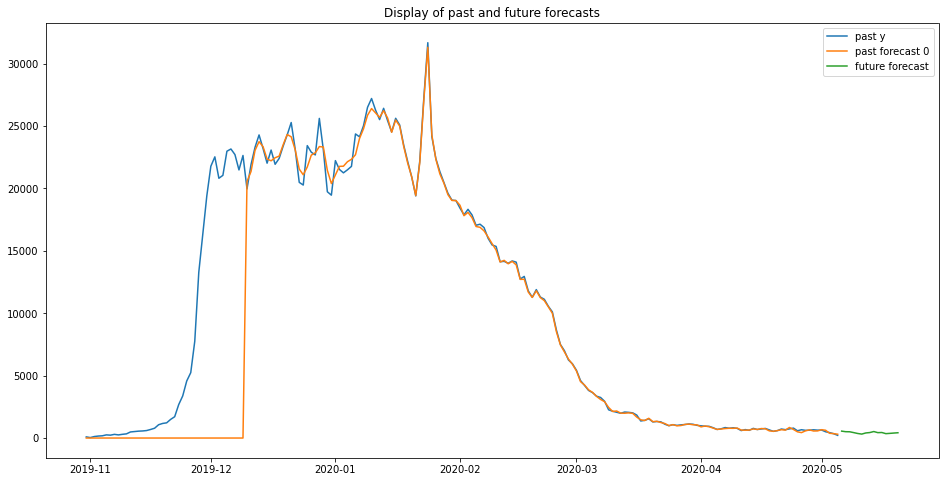

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,553,488 ~ 618,326.752045,2033 ~ 2576
2020-05-07,508,450 ~ 566,291.058228,1876 ~ 2360
2020-05-08,501,436 ~ 566,326.180237,1818 ~ 2360
2020-05-09,435,371 ~ 499,320.916840,1547 ~ 2080
2020-05-10,364,293 ~ 435,357.589050,1222 ~ 1816
2020-05-11,316,247 ~ 386,348.702789,1029 ~ 1609
2020-05-12,407,335 ~ 479,360.776184,1399 ~ 1998
2020-05-13,439,372 ~ 506,337.886536,1550 ~ 2112
2020-05-14,520,445 ~ 595,375.779449,1857 ~ 2482


In [72]:
#		4.1.4 40일 window, 1일 예측 후 15일 재귀적 예측 Ensemble CNN Model Test

window = 40
forecast=1
train_x,train_y,predict_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y_iso_cov_ns,window=window, forecast=forecast)

ensemble_model = ensemble_train(train_x,train_y,ensemble_count=100,epoch=100)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
predict_x_y,ensemble_predict_x_y = ensemble_recursive_forecast(ensemble_model,predict_x)
ds_s_r = statistical_results_analysis(ensemble_predict_x_y,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,553.262207,2305
2020-05-07,508.451538,2118
2020-05-08,501.379639,2089
2020-05-09,435.314301,1813
2020-05-10,364.630585,1519
2020-05-11,316.714355,1319
2020-05-12,407.743835,1698
2020-05-13,439.565155,1831
2020-05-14,520.751160,2169


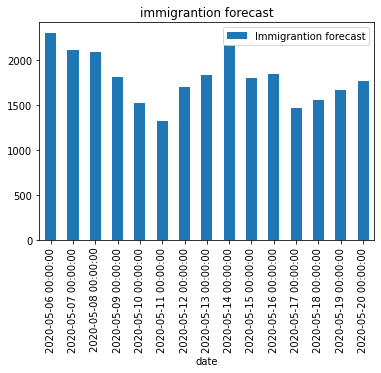

In [73]:
#	5.3 향후 15일 예측 결과

display_result(predict_x_y,ds_y)